In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import glob
import os

import matplotlib.pyplot as plt


# Dataset Class

In [2]:
class VelocityDataset(Dataset):
    def __init__(self, root_dir):
        self.velocity_files = []
        self.terrain_files = {}
        
        # Function to extract the state number from the file name
        def get_state_number(file_path):
            # Assuming the file name format is 'XXXXX_velocity_STATE.npy'
            return int(file_path.split('_')[-1].split('.')[0])

        # Find all model directories
        model_dirs = glob.glob(os.path.join(root_dir, '*'))
        for model_dir in model_dirs:
            if os.path.isdir(model_dir):
                # Find all velocity files in the model directory
                velocity_pattern = os.path.join(model_dir, '04_FinalProcessedData_128', 'velocity', '*_velocity_*.npy')
                # Sort the files based on the state number
                velocity_files = sorted(glob.glob(velocity_pattern), key=get_state_number)
                
                # Find the corresponding terrain file in the model directory
                terrain_pattern = os.path.join(model_dir, '04_FinalProcessedData_128', 'elevation', '*_elevation.npy')
                terrain_file = sorted(glob.glob(terrain_pattern))
                
                if terrain_file:
                    # Assuming there is only one terrain file per model directory
                    self.terrain_files[model_dir] = terrain_file[0]
                
                # Ensure that we pair each velocity file with the subsequent one if the states are sequential
                for i in range(len(velocity_files) - 1):
                    current_state = get_state_number(velocity_files[i])
                    next_state = get_state_number(velocity_files[i + 1])
                    
                    # Check if the subsequent file is the next state
                    if next_state == current_state + 1:
                        self.velocity_files.append((velocity_files[i], velocity_files[i + 1]))
        
    def __len__(self):
        return len(self.velocity_files)
    
    def __getitem__(self, idx):
        current_velocity_path, next_velocity_path = self.velocity_files[idx]
        current_velocity = np.load(current_velocity_path)
        next_velocity = np.load(next_velocity_path)
        
        # Get the model directory from the current velocity path
        model_dir = os.path.dirname(os.path.dirname(os.path.dirname(current_velocity_path)))
        
        # Load the corresponding terrain file
        terrain_path = self.terrain_files[model_dir]
        terrain = np.load(terrain_path)
        
        # Stack terrain and velocity arrays as channels for CNN input
        cnn_input = np.stack((terrain, current_velocity), axis=0)
        
        return torch.from_numpy(cnn_input).float(), torch.from_numpy(next_velocity).float().unsqueeze(0)

# CNNs


## Simple CNN

In [3]:
# Define the neural network architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

## More Complex CNN

In [4]:
class VelocityPredictionCNN(nn.Module):
    def __init__(self):
        super(VelocityPredictionCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)  # Input: 2 channels, Output: 32 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 1, kernel_size=3, padding=1)  # Output: 1 channel (velocity)

    def forward(self, x):
        # Encoder path
        x1 = F.relu(self.bn1(self.conv1(x)))     # 64x64x32
        x2 = self.pool(x1)                       # 32x32x32
        x3 = F.relu(self.bn2(self.conv2(x2)))    # 32x32x64
        x4 = self.pool(x3)                       # 16x16x64
        x5 = F.relu(self.bn3(self.conv3(x4)))    # 16x16x128
        x6 = self.pool(x5)                       # 8x8x128
        x7 = F.relu(self.bn4(self.conv4(x6)))    # 8x8x256

        # Decoder path
        x8 = self.up(x7)                         # 16x16x256
        x9 = F.relu(self.bn5(self.conv5(x8)))    # 16x16x128
        x10 = self.up(x9)                        # 32x32x128
        x11 = F.relu(self.bn6(self.conv6(x10)))  # 32x32x64
        x12 = self.up(x11)                       # 64x64x64

        # Output layer
        x13 = self.conv7(x12)                    # 64x64x1
        return x13


## UNet

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Define the U-Net architecture
        # Contracting Path (Encoder)
        self.enc_conv0 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Expanding Path (Decoder)
        self.up_conv0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dec_conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)  # Output: 1 channel (velocity)

    def forward(self, x):
        # Encoder
        enc0 = F.relu(self.enc_conv0(x))
        enc1 = F.relu(self.enc_conv1(self.pool(enc0)))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Decoder
        dec2 = F.relu(self.dec_conv1(torch.cat((self.up_conv0(enc3), enc2), dim=1)))
        dec1 = F.relu(self.dec_conv2(torch.cat((self.up_conv1(dec2), enc1), dim=1)))
        dec0 = F.relu(self.dec_conv3(torch.cat((self.up_conv2(dec1), enc0), dim=1)))

        # Final convolution
        return self.final_conv(dec0)

# Model Set Up

In [6]:
# Data
root_dir = 'C:\\Users\\thomas.bush\\repos\\dyna-landslide-surrogate\\data_small'
dataset = VelocityDataset(root_dir)

In [7]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

Training on device: cuda.


In [8]:
# Split dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model and move it to GPU if available
# model = VelocityPredictionCNN().to(device)
model = UNet().to(device)


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:

print(f"Total dataset size: {len(dataset)}")

# Calculate train and test sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(f"Train size: {train_size}, Test size: {test_size}")

# Make sure the sizes are positive
if train_size <= 0 or test_size <= 0:
    raise ValueError("Train size and test size must be positive.")

# Split dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Make sure the datasets after split are not empty
print(f"Size of train_dataset: {len(train_dataset)}")
print(f"Size of test_dataset: {len(test_dataset)}")

if len(train_dataset) == 0 or len(test_dataset) == 0:
    raise ValueError("The train_dataset or test_dataset is empty.")

Total dataset size: 2297
Train size: 1837, Test size: 460
Size of train_dataset: 1837
Size of test_dataset: 460


In [10]:
# Function to train the model and plot loss, modified to use CUDA
def train_and_plot(model, loader, optimizer, criterion, epochs, device):
    # Create a directory for model checkpoints if it doesn't exist
    os.makedirs('model_checkpoints', exist_ok=True)
    
    model.train()
    epoch_losses = []  # List to store average loss per epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, (current, next_velocity) in enumerate(loader):
            # Move data to device
            current = current.to(device)
            next_velocity = next_velocity.to(device)
            
            optimizer.zero_grad()
            predictions = model(current)
            loss = criterion(predictions, next_velocity)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()  # Aggregate loss for the epoch



        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(loader)
        epoch_losses.append(avg_epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.4f}')

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_dir = 'model_checkpoints_128'
            os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist
            checkpoint_path = f'{checkpoint_dir}/model_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')

    # After training, plot the loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [11]:
# Function to test the model on test data

def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for current, next_velocity in loader:
            # Move data to device
            current = current.to(device)
            next_velocity = next_velocity.to(device)
            
            predictions = model(current)
            loss = criterion(predictions, next_velocity)
            total_loss += loss.item()
    print(f'Test Loss: {total_loss / len(loader):.4f}')



# Execute Training and Testing

In [12]:

train_and_plot(model, train_loader, optimizer, criterion, epochs=50, device='cuda')

Epoch [1/50], Average Loss: 17.4286
Epoch [2/50], Average Loss: 0.6953
Epoch [3/50], Average Loss: 0.5091
Epoch [4/50], Average Loss: 0.4776
Epoch [5/50], Average Loss: 0.4784
Model saved to model_checkpoints_128/model_epoch_5.pth


KeyboardInterrupt: 

In [13]:
test(model, test_loader, criterion, device=device)

Test Loss: 0.5274


In [14]:
def plot_random_pairs(dataset, n, colormin, colormax):
    # Randomly choose n indices
    indices = np.random.choice(len(dataset), n, replace=False)
    
    fig, axs = plt.subplots(n, 2, figsize=(10, n * 5))
    
    for i, idx in enumerate(indices):
        # Get the data pair
        cnn_input, next_velocity = dataset[idx]
        
        # Convert tensors to numpy arrays
        terrain = cnn_input[0].numpy()
        current_velocity = cnn_input[1].numpy()
        next_velocity = next_velocity[0].numpy()  # Remove channel dimension
        
        # Plot the terrain + current velocity
        im = axs[i, 0].imshow(current_velocity, cmap='viridis', vmin=colormin, vmax=colormax)
        axs[i, 0].set_title(f'Current Velocity (Index {idx})')
        axs[i, 0].axis('off')
        
        # Plot the next velocity
        axs[i, 1].imshow(next_velocity, cmap='viridis', vmin=colormin, vmax=colormax)
        axs[i, 1].set_title(f'Next Velocity (Index {idx})')
        axs[i, 1].axis('off')
    
    # Add a colorbar
    fig.colorbar(im, ax=axs[:, 1], fraction=0.015, pad=0.04)
    plt.show()

In [ ]:
plot_random_pairs(dataset, n=5, colormin=0, colormax=30)  # Adjust colormin and colormax as needed

In [15]:
import matplotlib.pyplot as plt


def plot_predictions(model, loader, device, num_batches=1):
    model.eval()
    with torch.no_grad():
        for _ in range(num_batches):
            # Extract a batch from the DataLoader
            current, next_velocity = next(iter(loader))
            
            # Move data to the appropriate device
            current = current.to(device)
            next_velocity = next_velocity.to(device)
            
            # Get model predictions
            predictions = model(current)
            
            # Move the tensors back to the CPU and convert to numpy for plotting
            current = current.cpu().numpy()
            next_velocity = next_velocity.cpu().numpy()
            predictions = predictions.cpu().numpy()
            
            # Calculate the differences
            differences = np.abs(next_velocity - predictions)
            
            # Determine the common color scale for current and next velocities
            velocity_min = np.min(current[:, 1, :, :])
            velocity_max = np.max(current[:, 1, :, :])
            next_velocity_min = np.min(next_velocity)
            next_velocity_max = np.max(next_velocity)
            common_velocity_scale_min = min(velocity_min, next_velocity_min)
            common_velocity_scale_max = max(velocity_max, next_velocity_max)
            
            batch_size = current.shape[0]
            
            for idx in range(batch_size):
                plt.figure(figsize=(20, 4))

                # Plot first channel of current image (topography)
                plt.subplot(1, 5, 1)
                plt.imshow(current[idx][0], cmap='gray')
                plt.title('Topography')
                plt.axis('off')

                # Plot second channel of current image (current velocity)
                plt.subplot(1, 5, 2)
                plt.imshow(current[idx][1], cmap='jet', vmin=common_velocity_scale_min, vmax=common_velocity_scale_max)
                plt.title('Current Velocity')
                plt.axis('off')
                plt.colorbar()

                # Plot true next_velocity image
                plt.subplot(1, 5, 3)
                plt.imshow(next_velocity[idx][0], cmap='jet', vmin=common_velocity_scale_min, vmax=common_velocity_scale_max)
                plt.title('True Next Velocity')
                plt.axis('off')
                plt.colorbar()

                # Plot predicted next_velocity
                plt.subplot(1, 5, 4)
                plt.imshow(predictions[idx][0], cmap='jet', vmin=common_velocity_scale_min, vmax=common_velocity_scale_max)
                plt.title('Predicted Next Velocity')
                plt.axis('off')
                plt.colorbar()

                # Plot difference chart
                plt.subplot(1, 5, 5)
                plt.imshow(differences[idx][0], cmap='jet')  # Use the default color scale for differences
                plt.title('Difference Chart')
                plt.axis('off')
                plt.colorbar()

                plt.show()
            break  # Only plot for the first batch



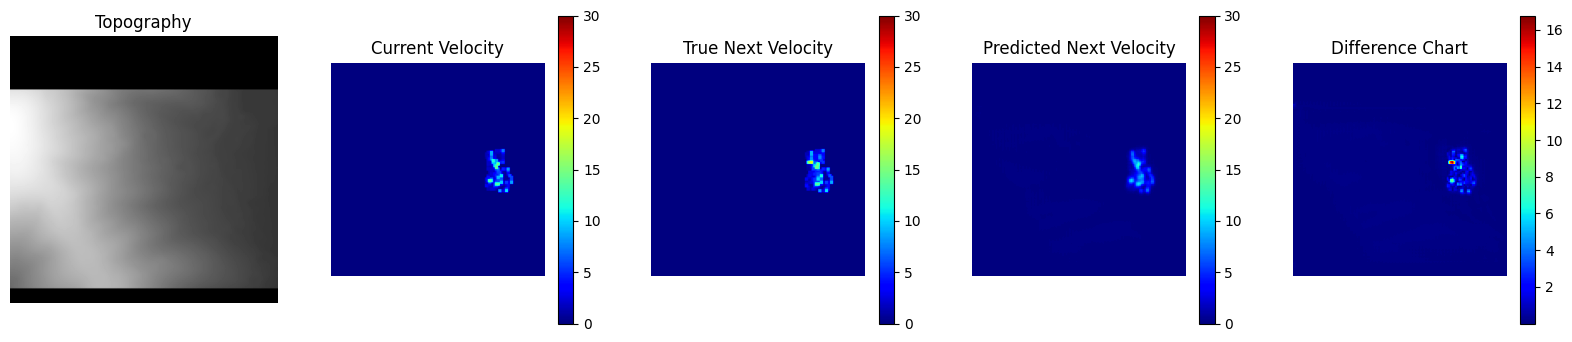

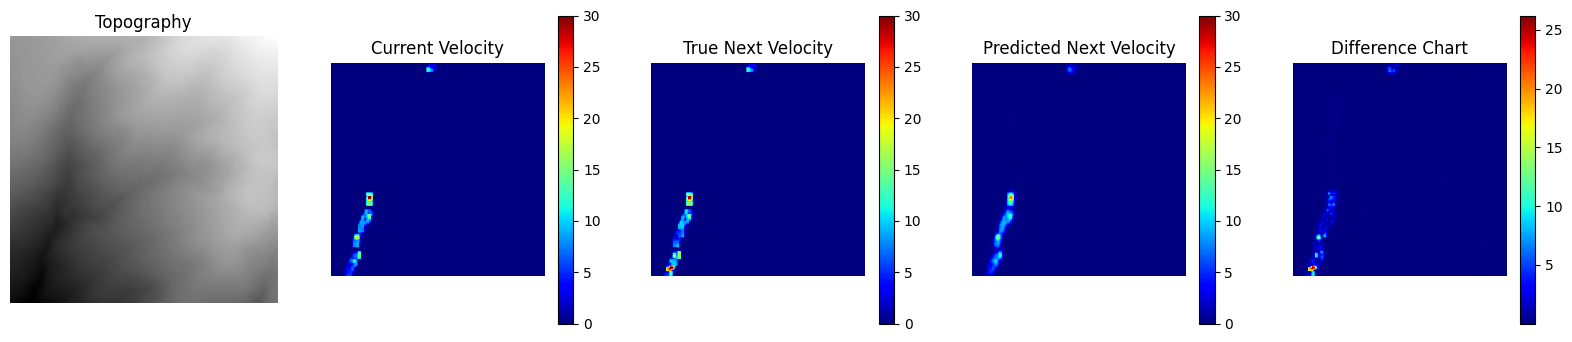

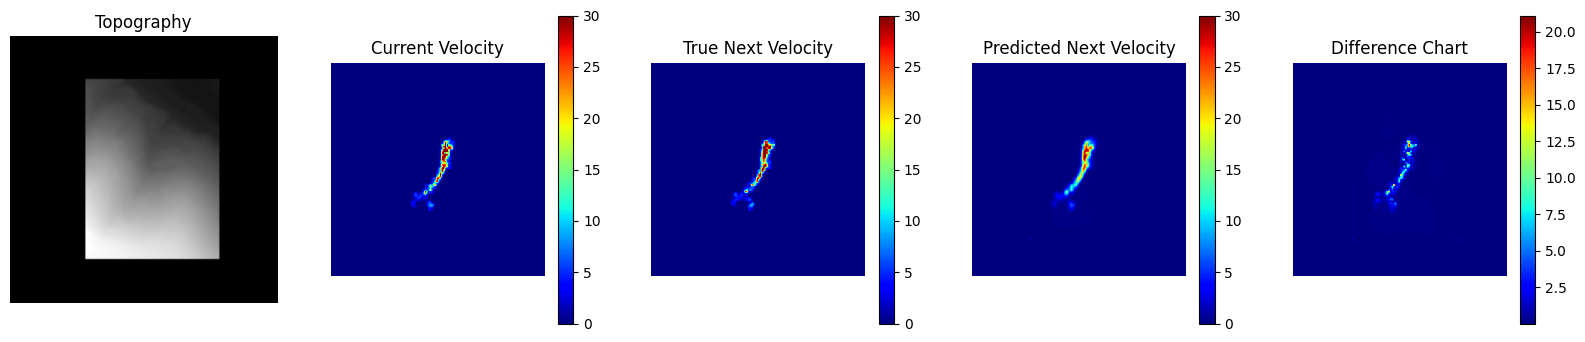

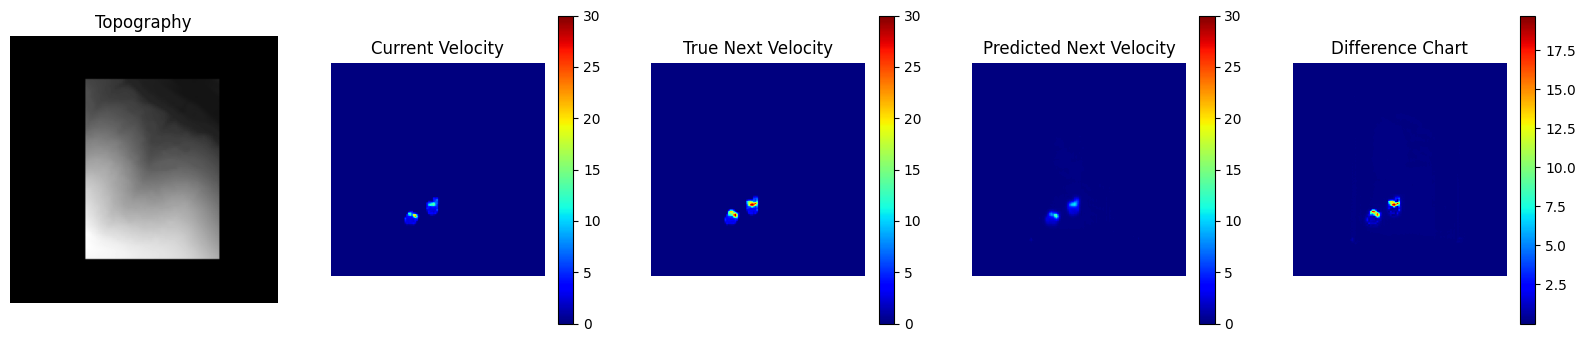

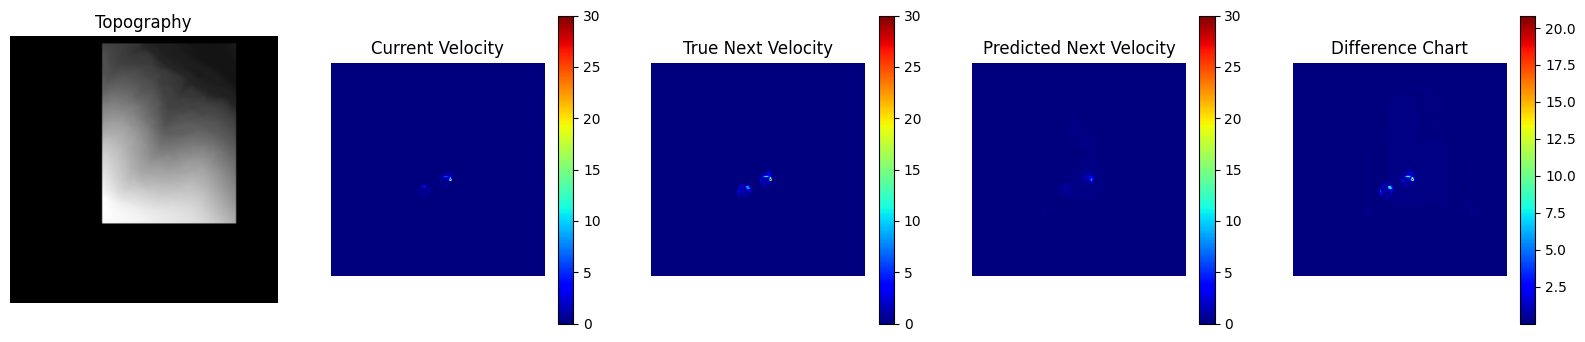

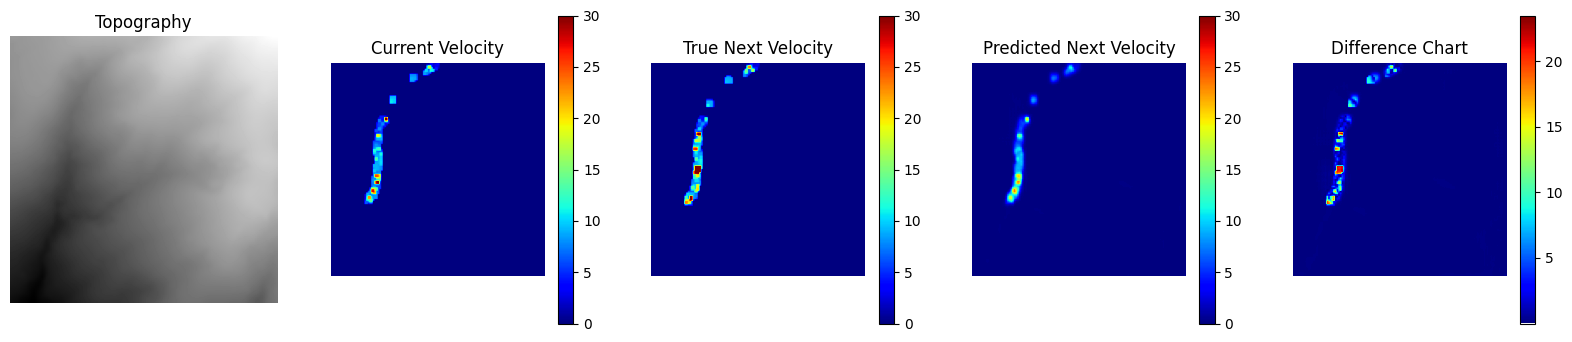

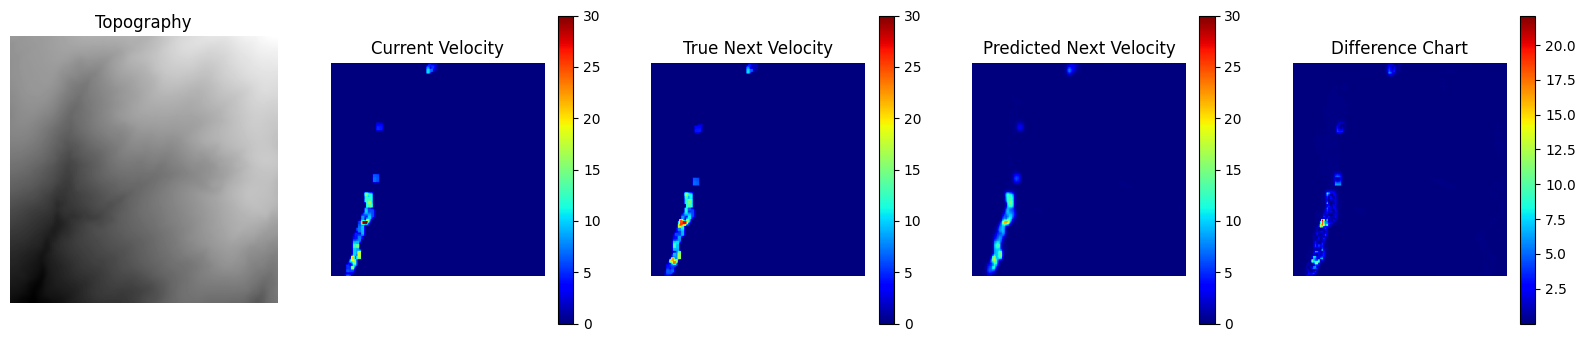

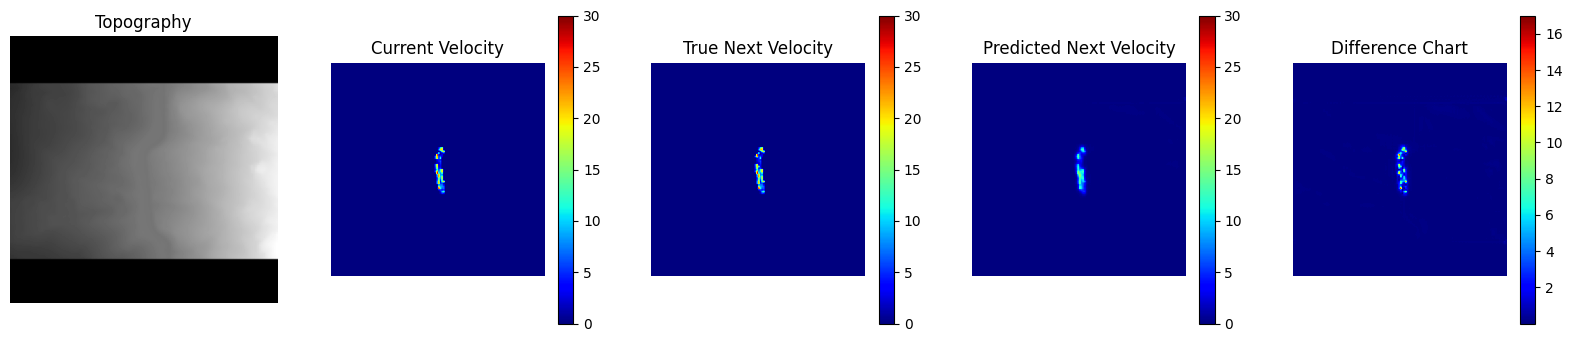

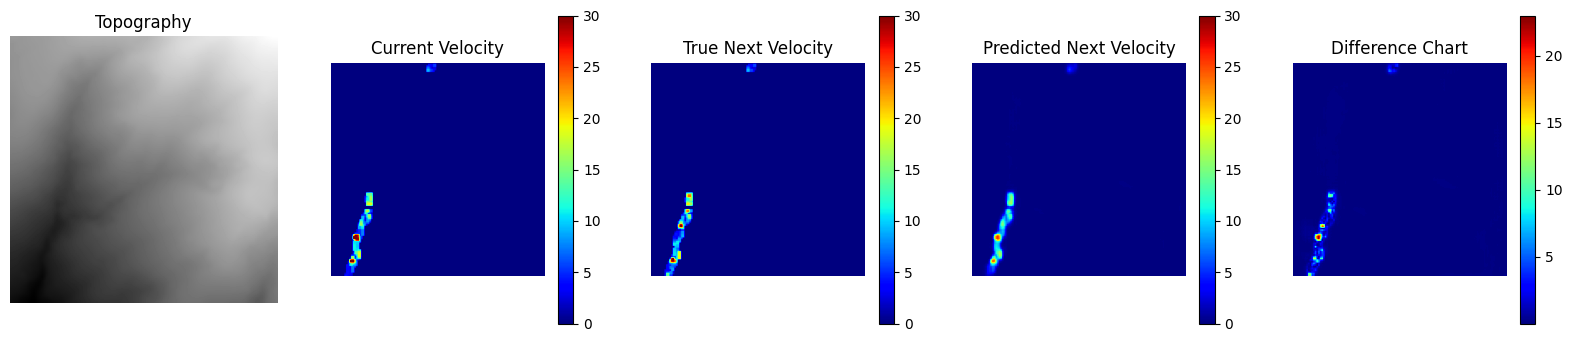

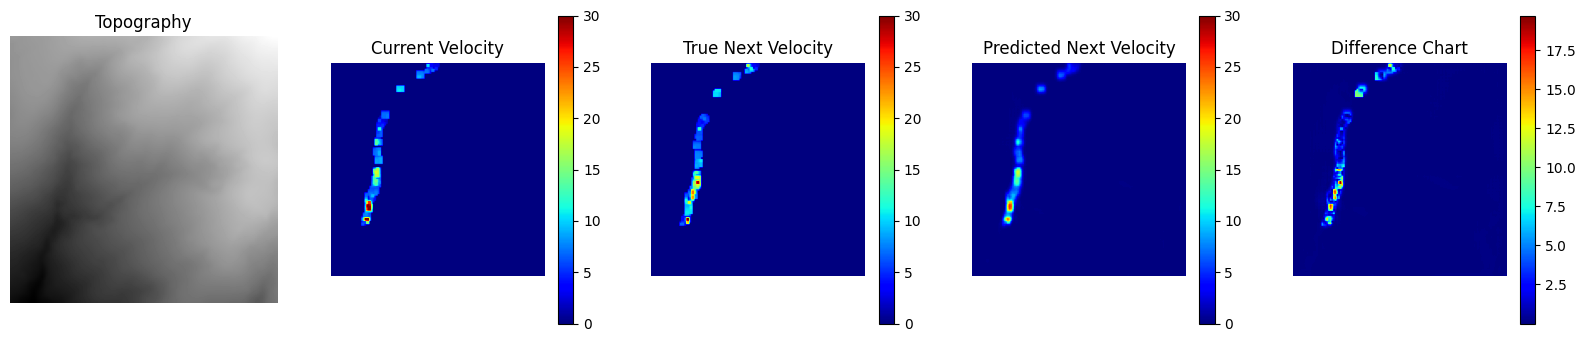

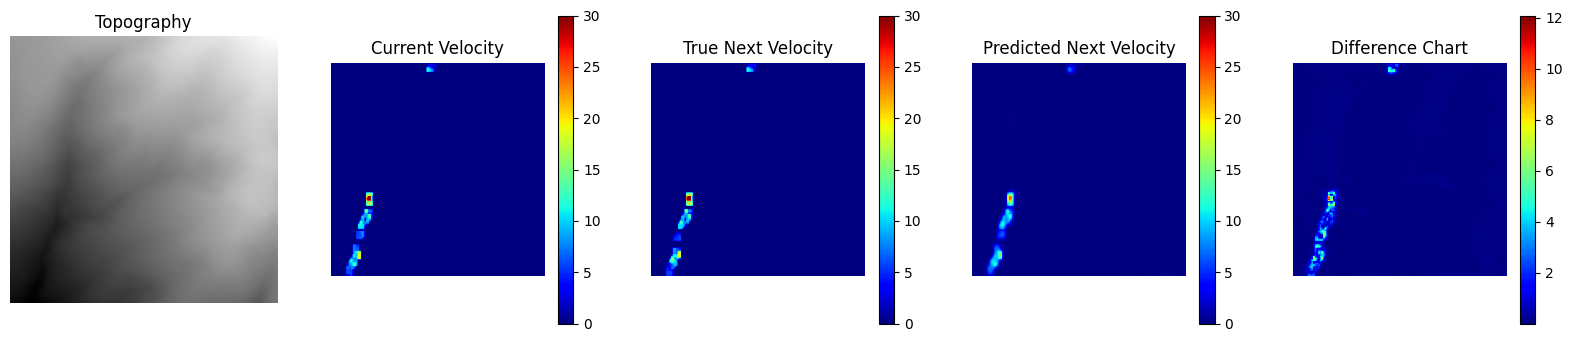

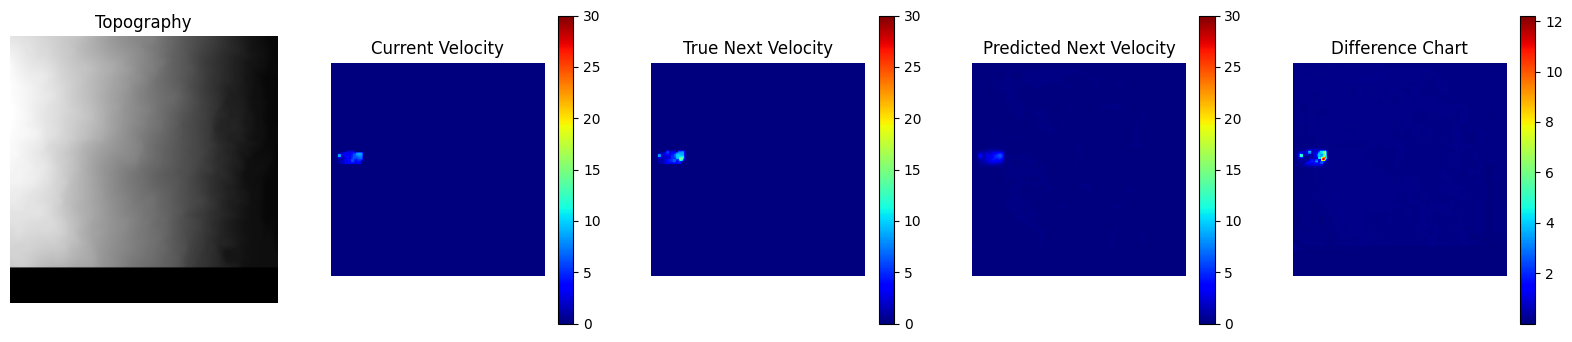

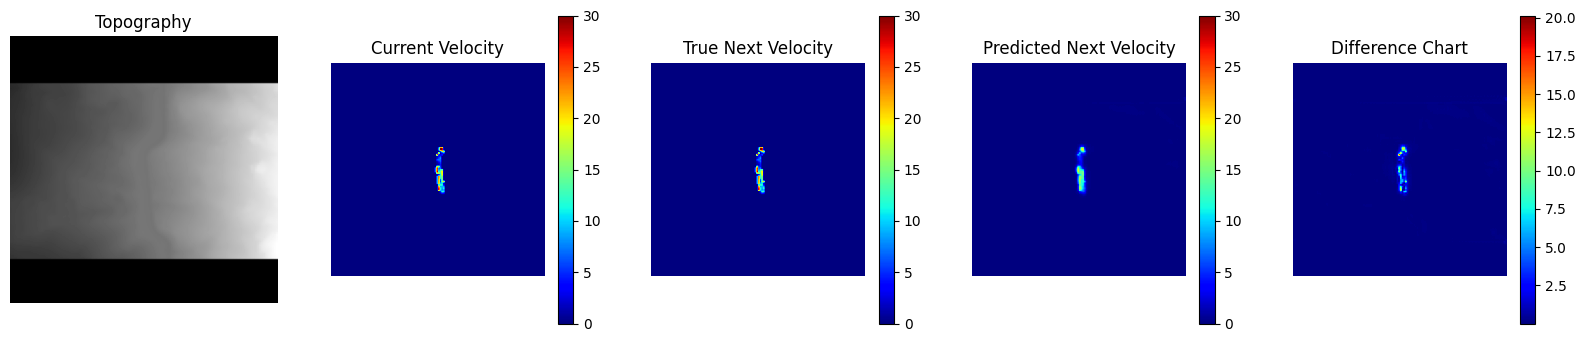

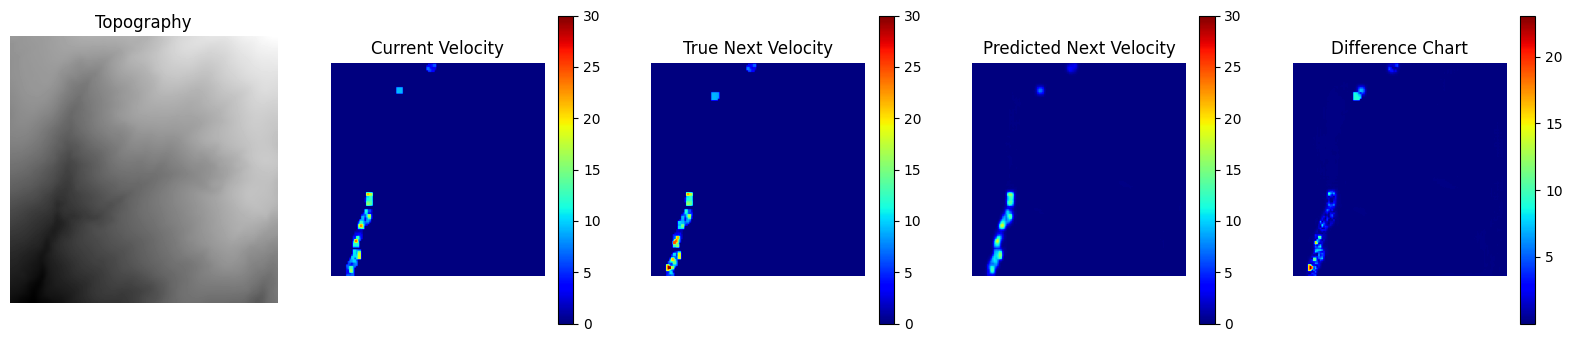

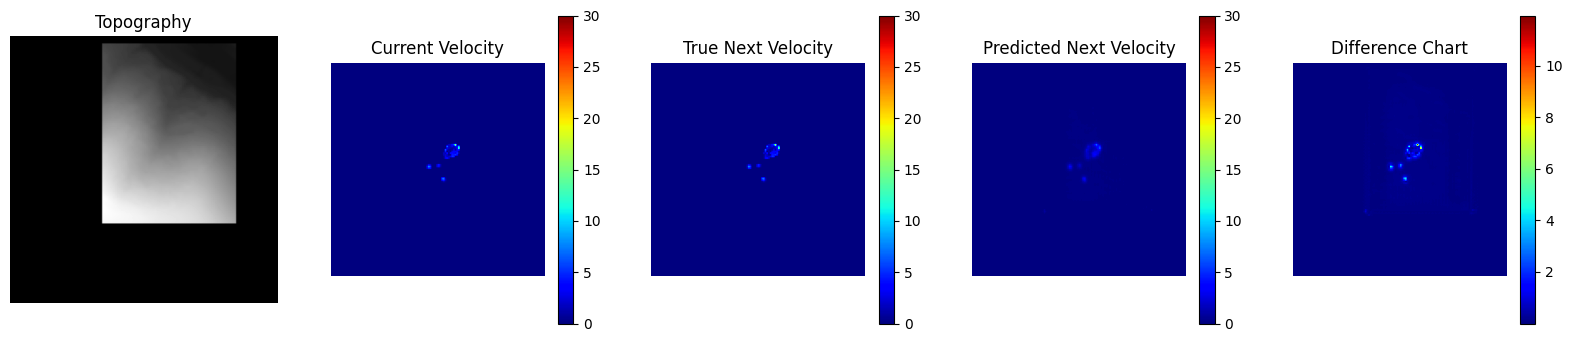

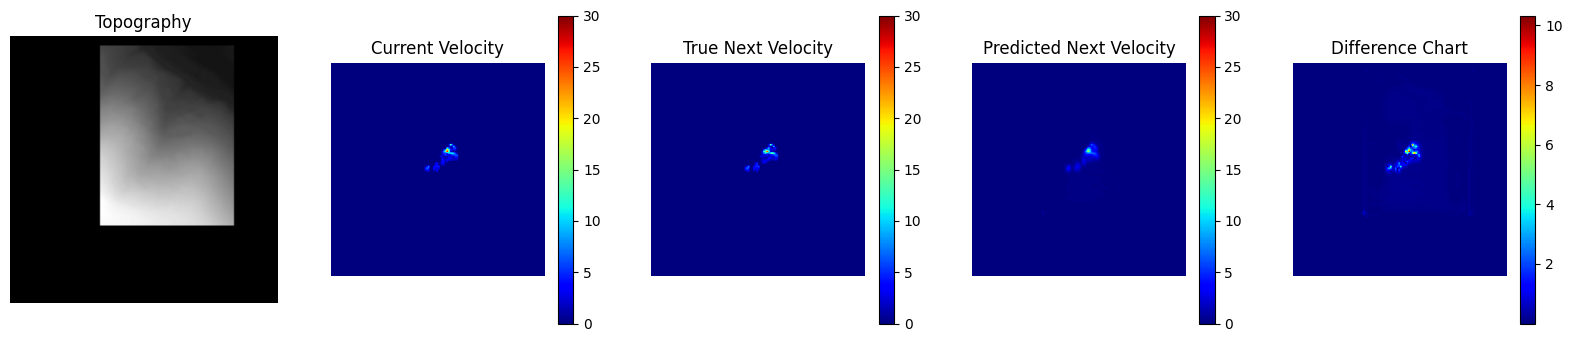

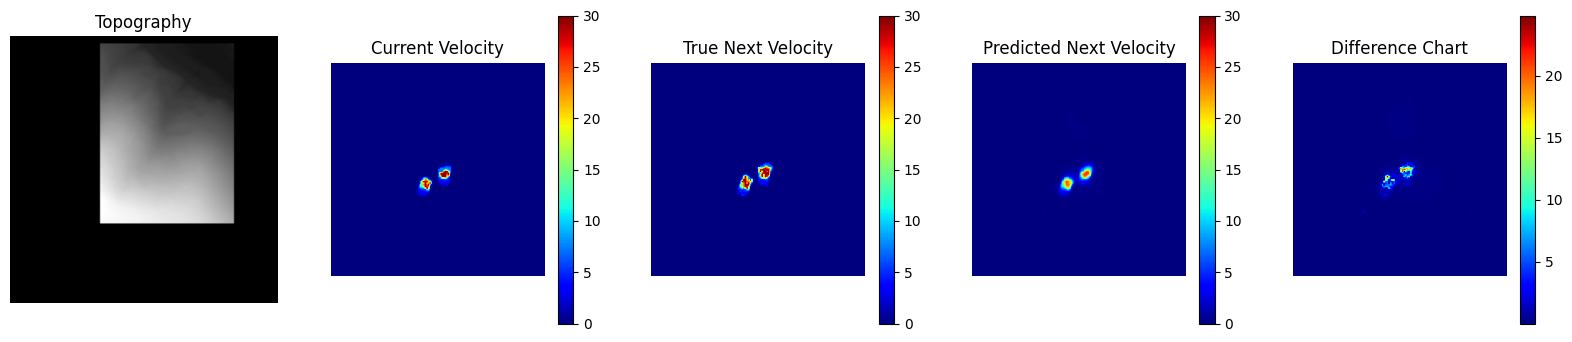

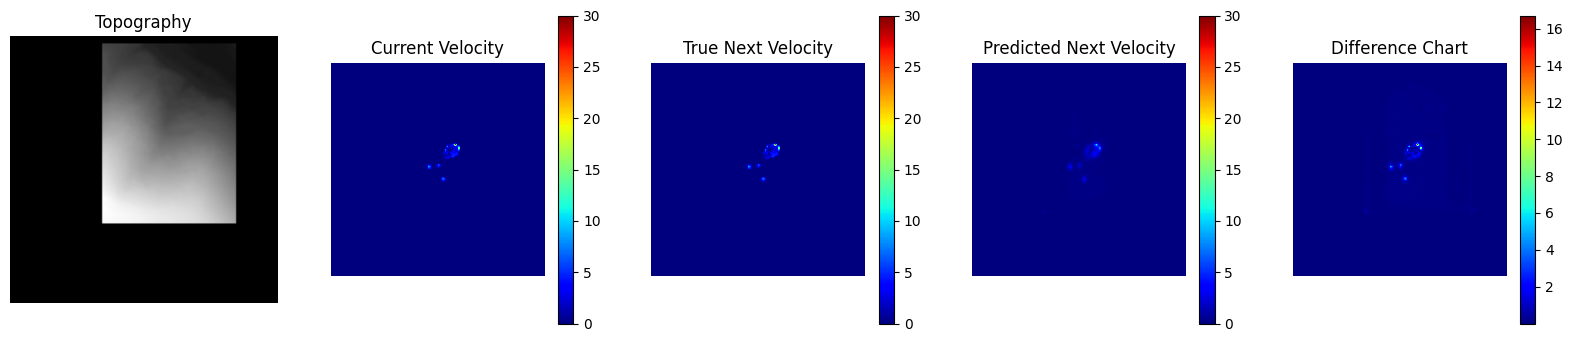

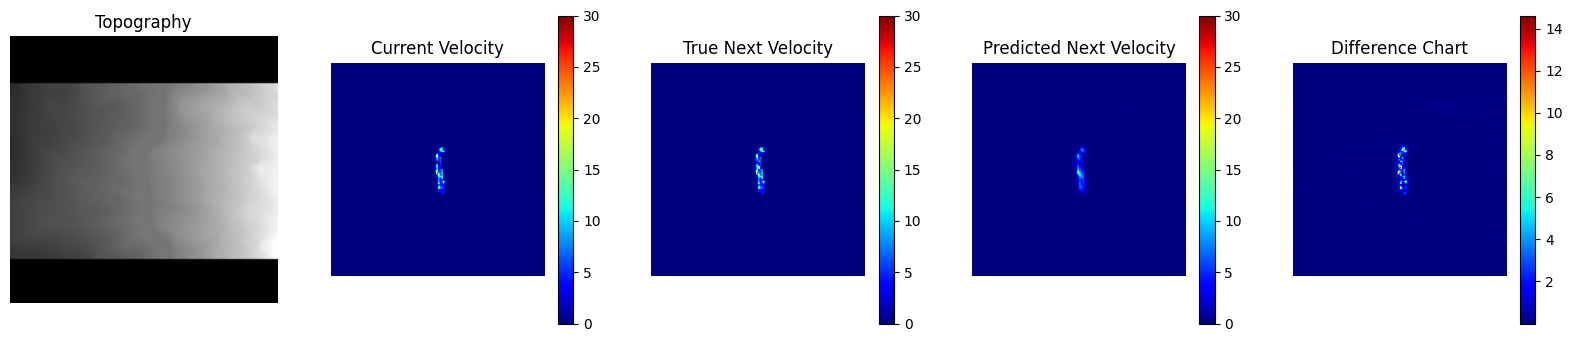

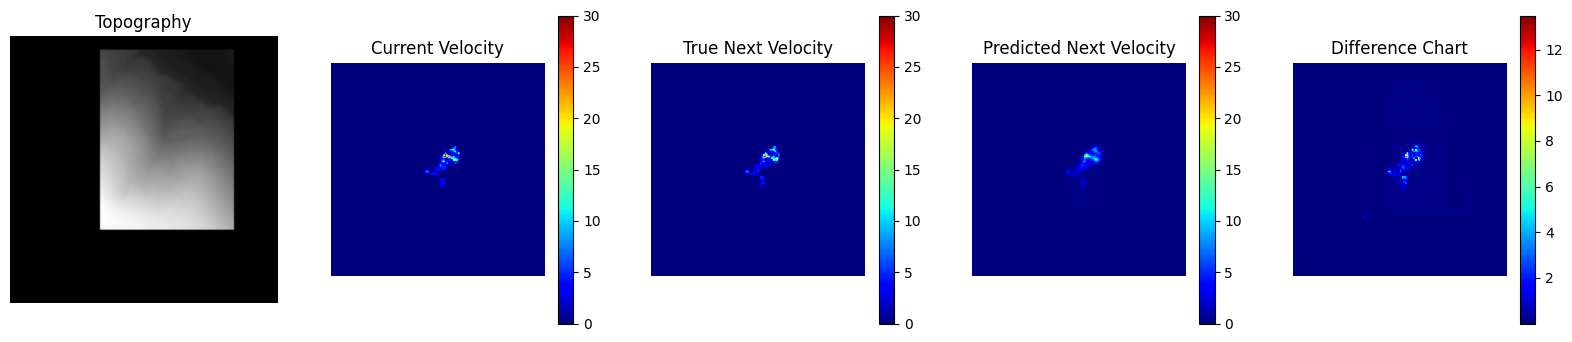

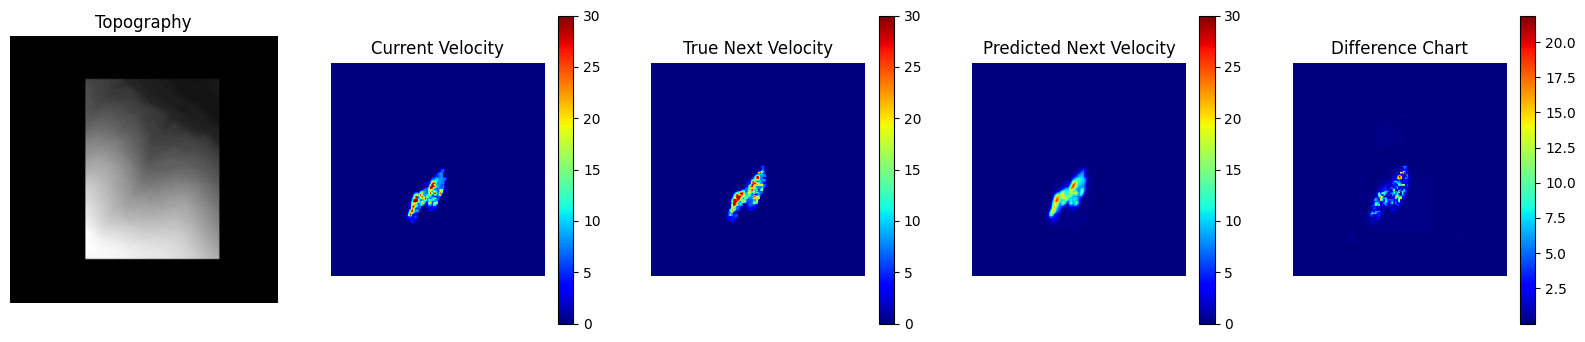

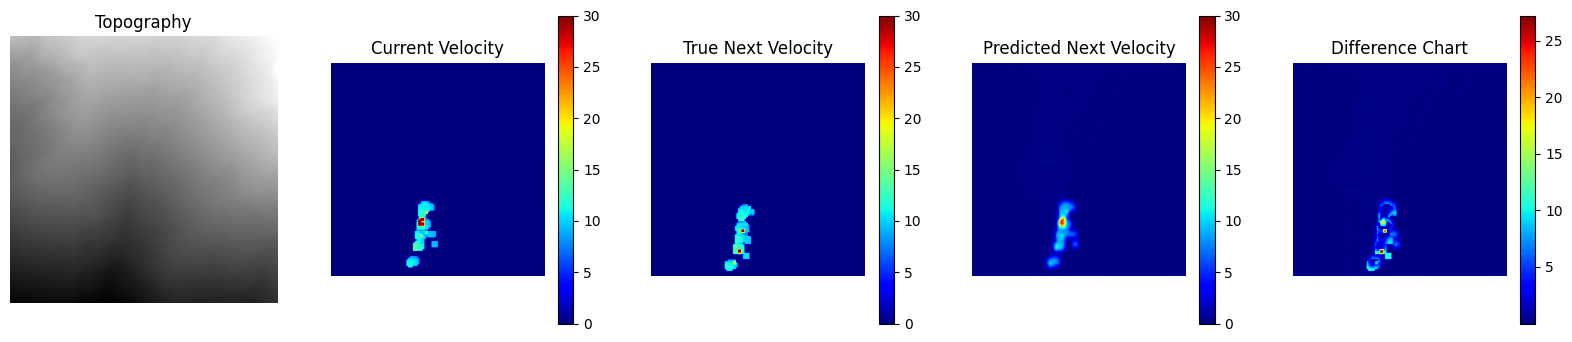

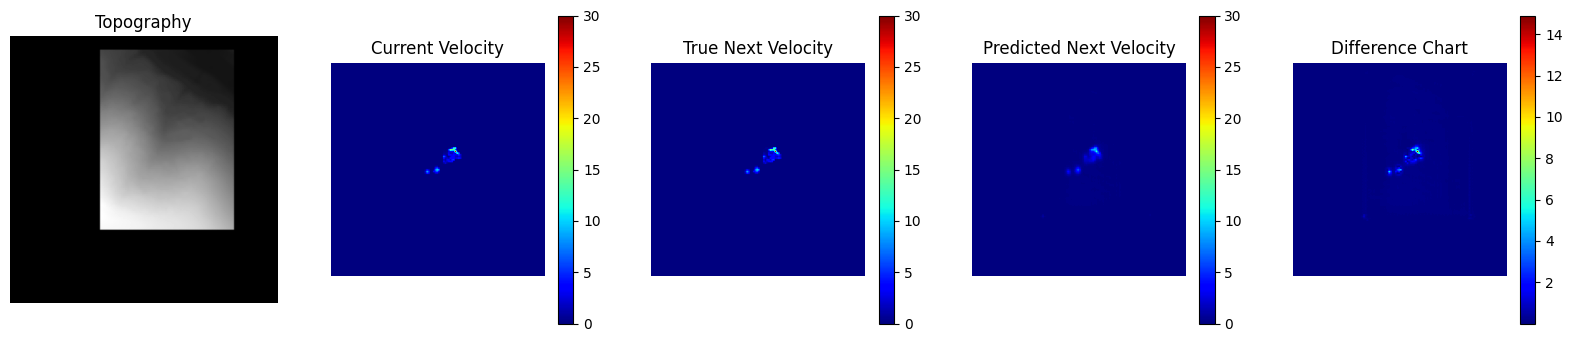

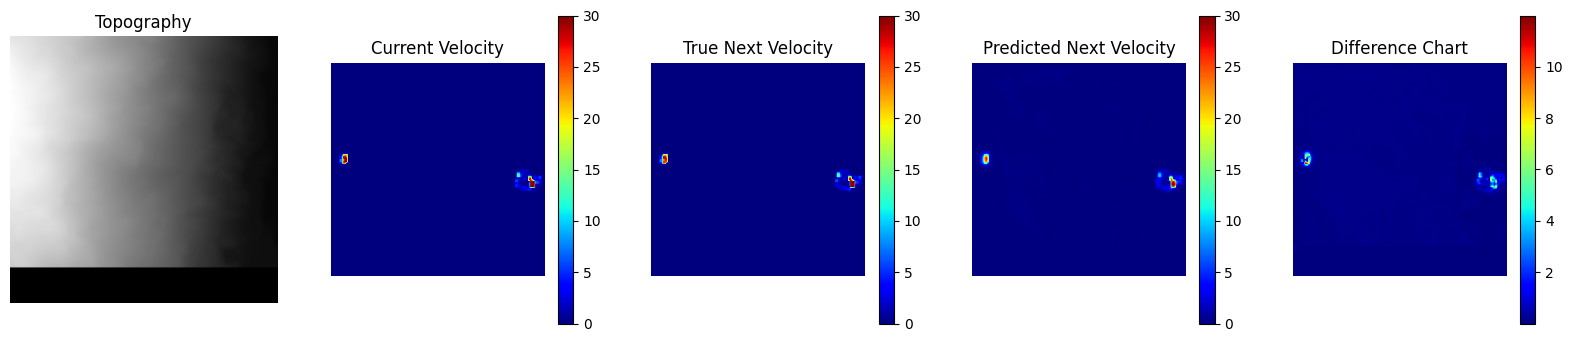

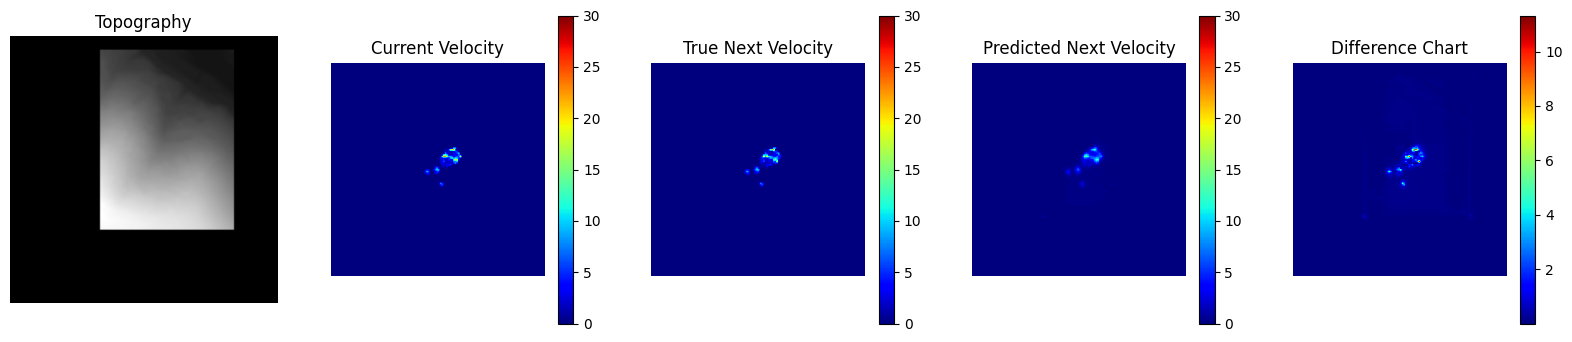

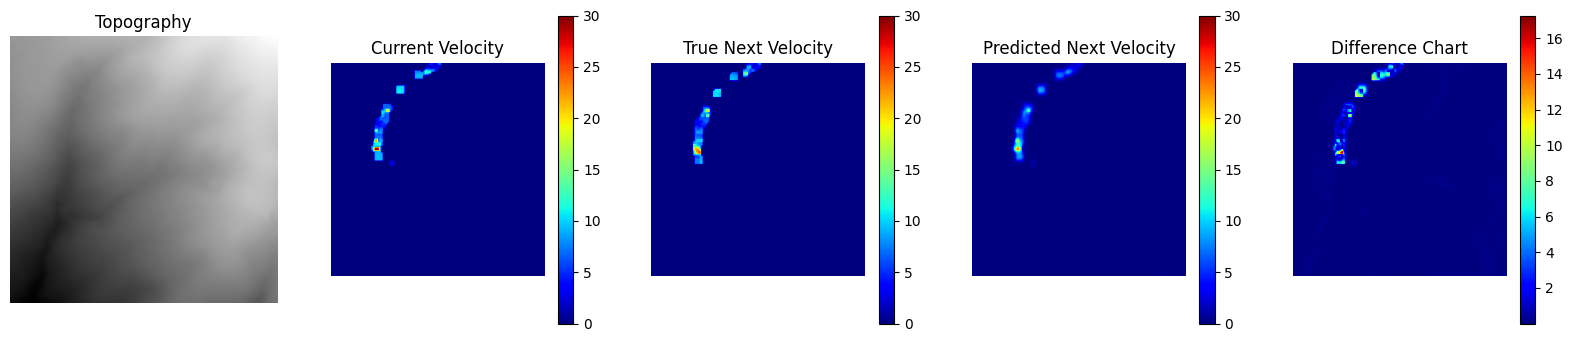

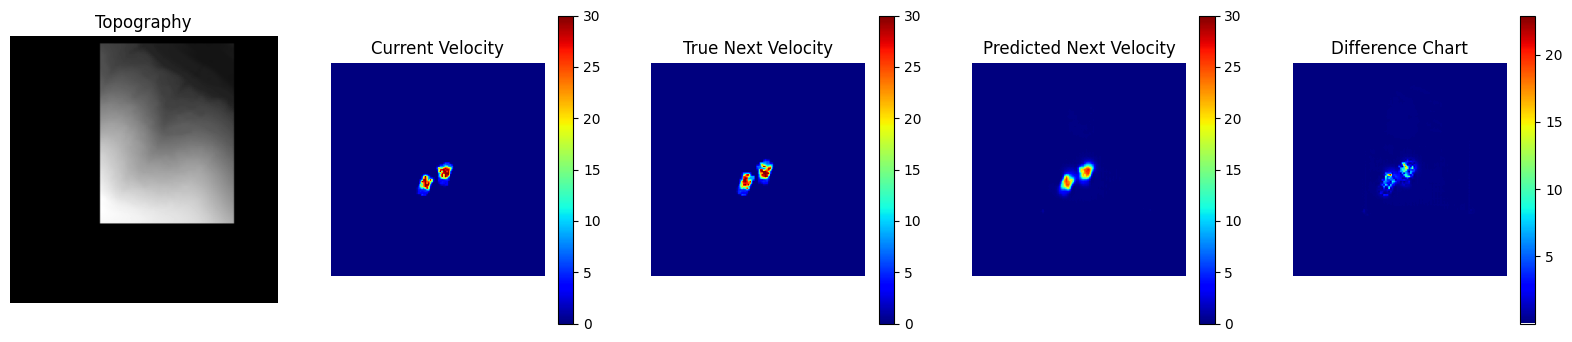

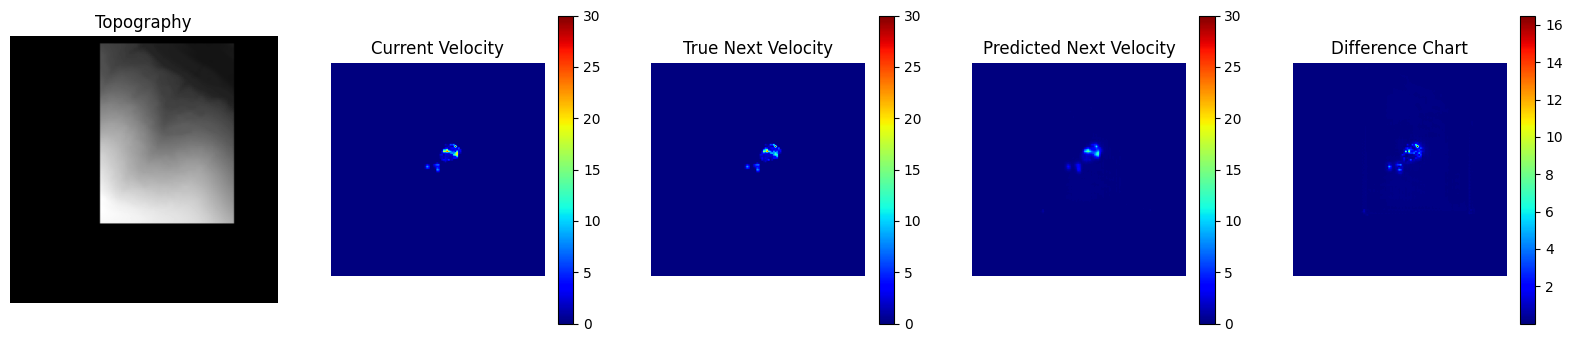

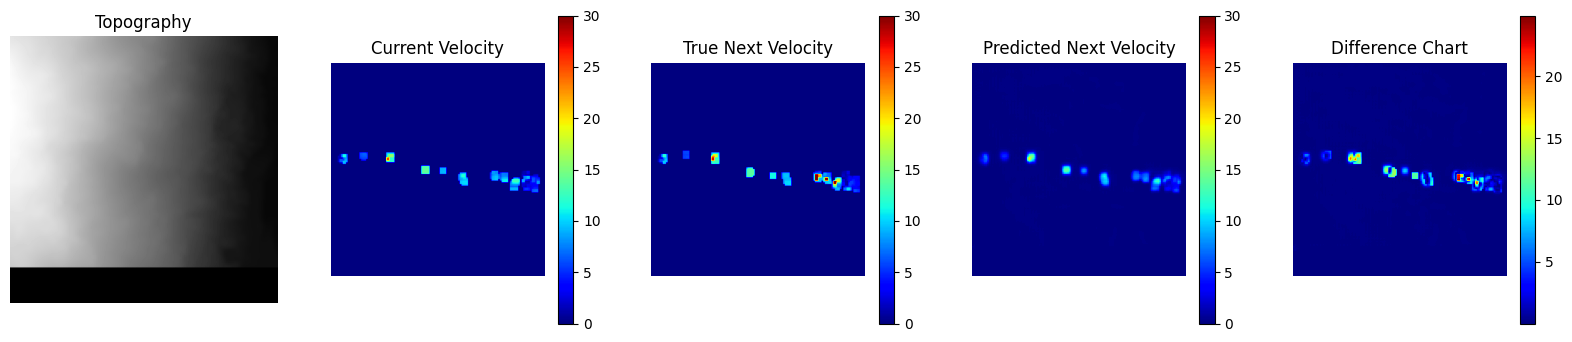

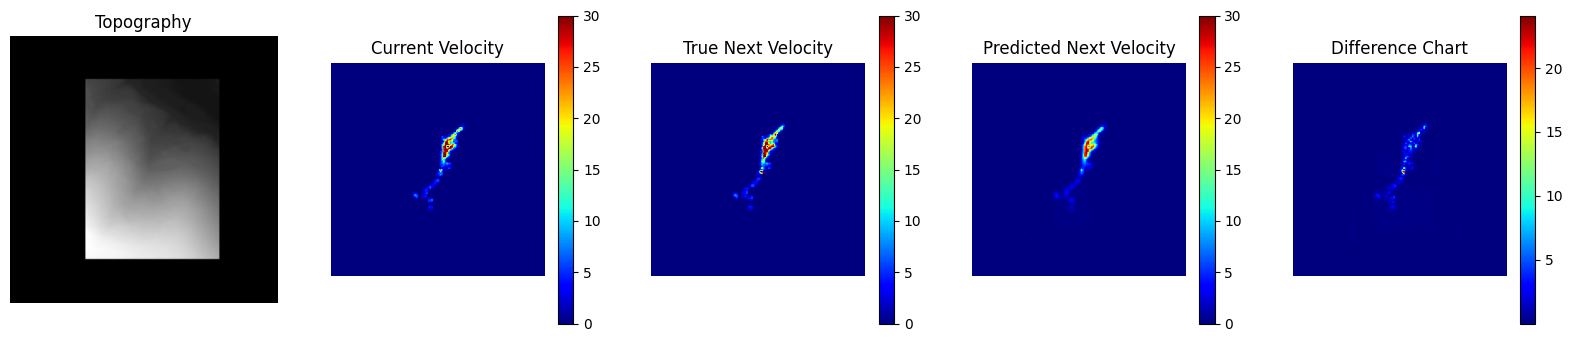

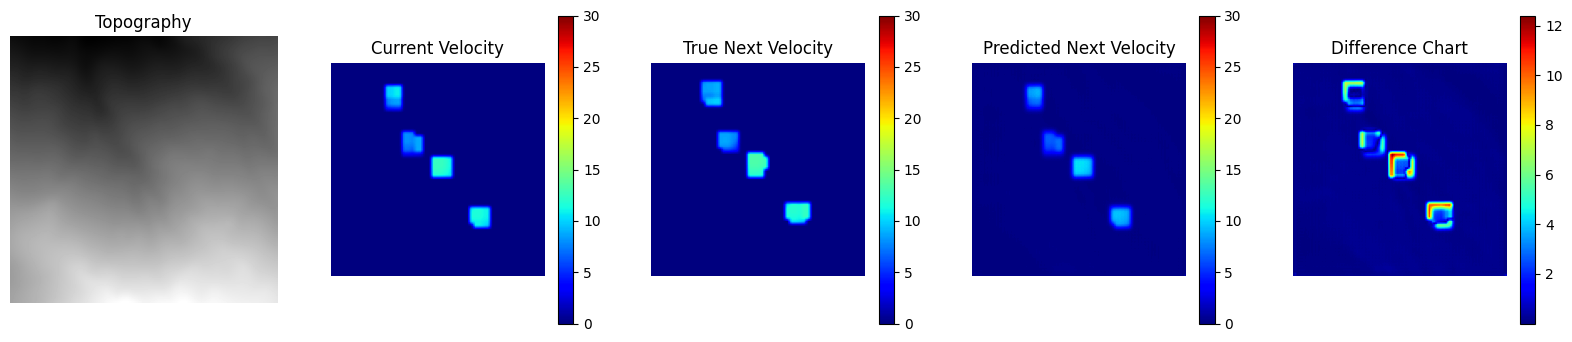

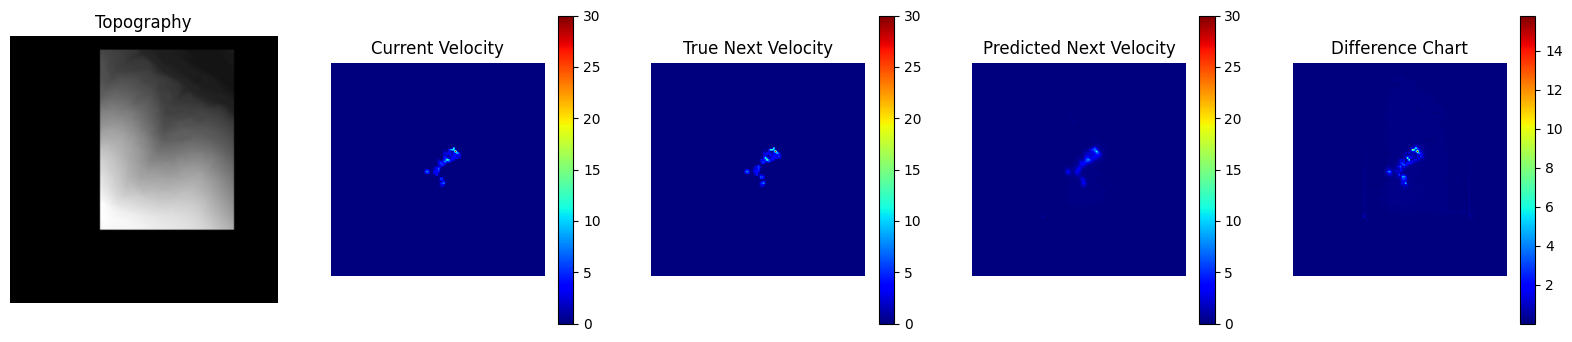

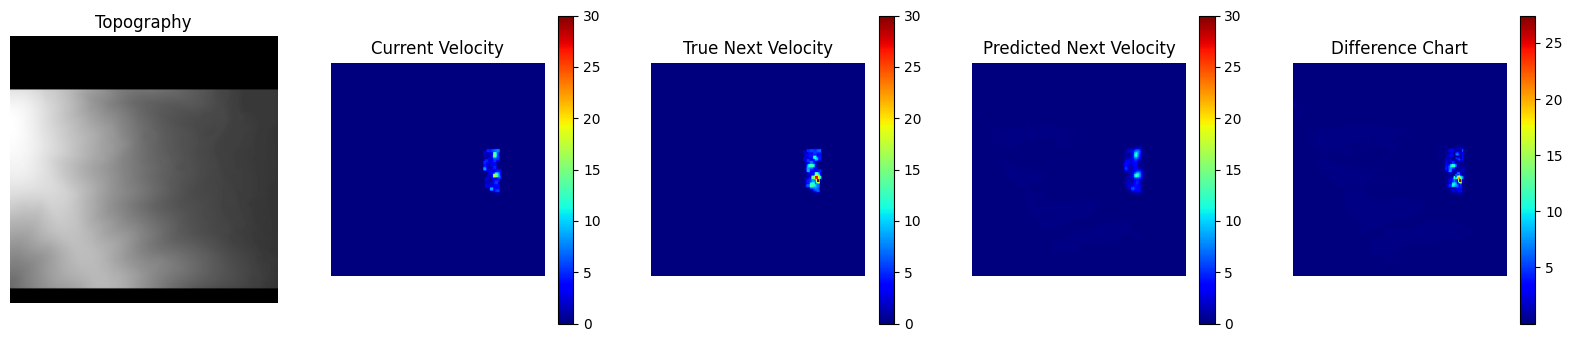

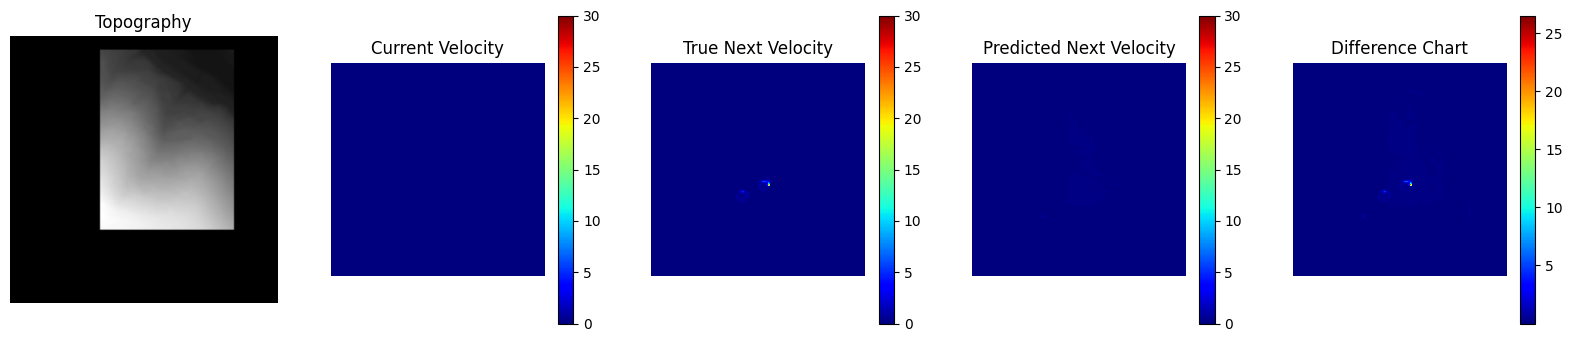

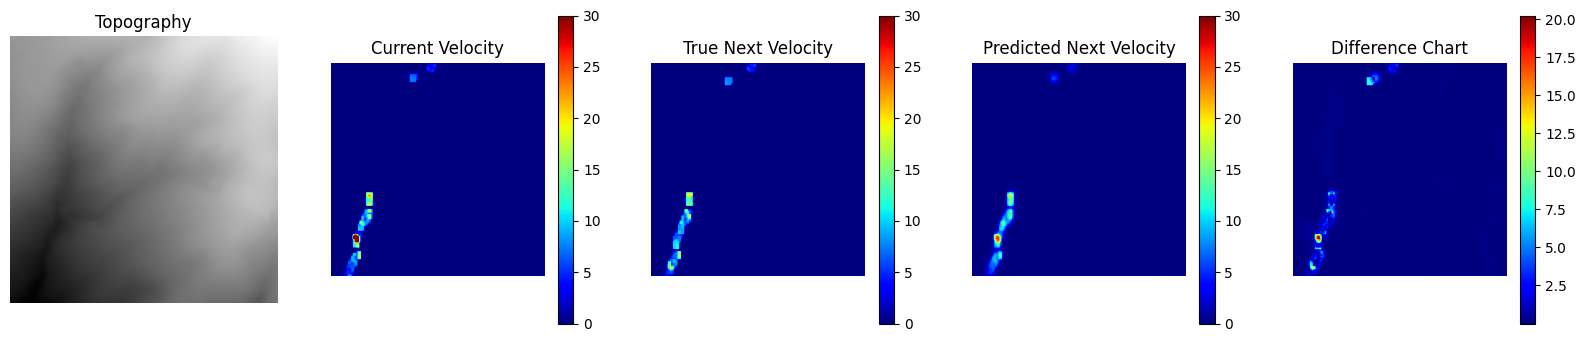

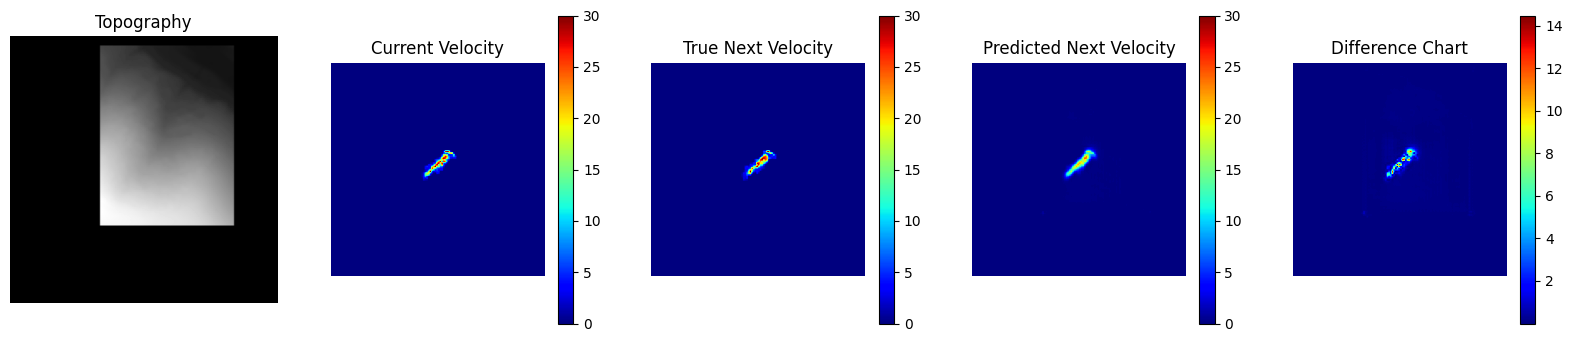

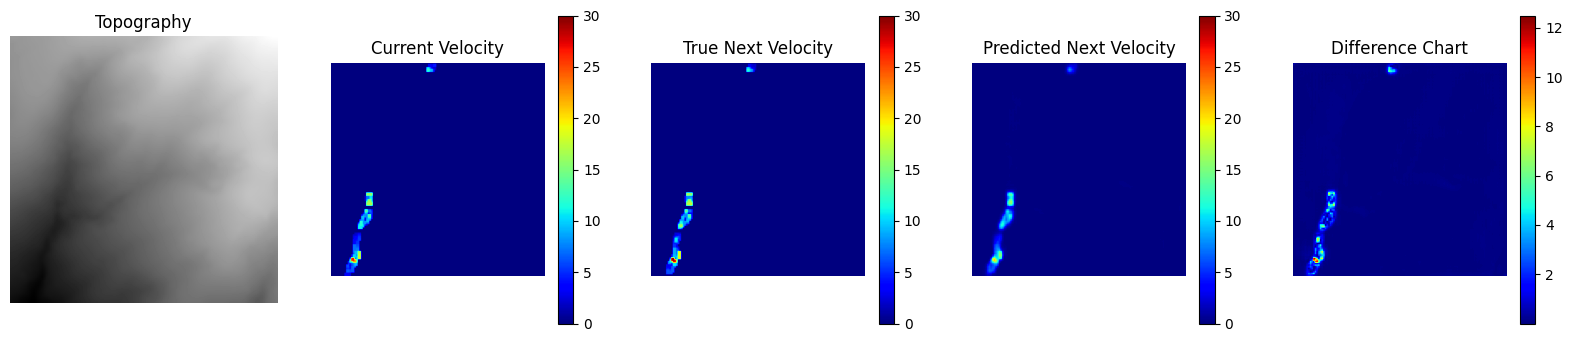

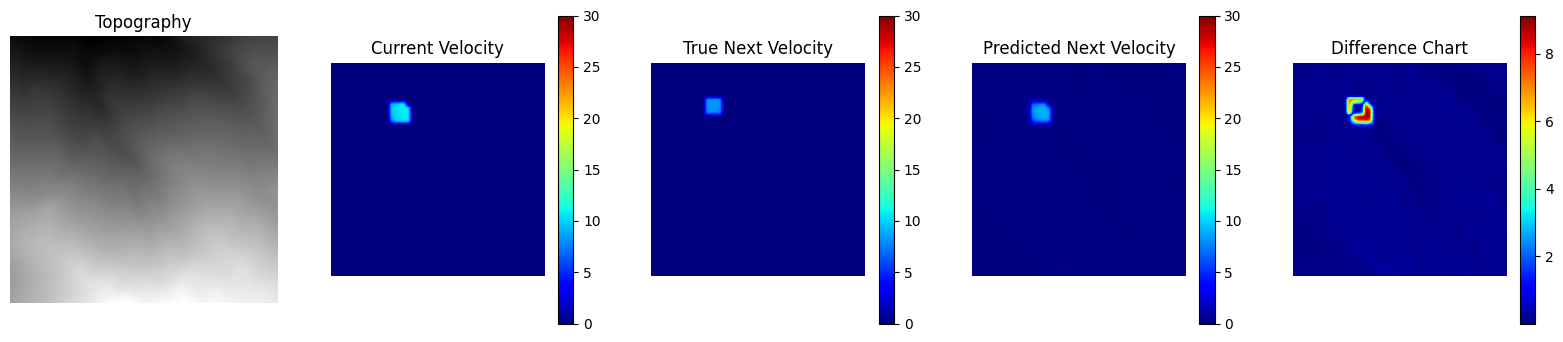

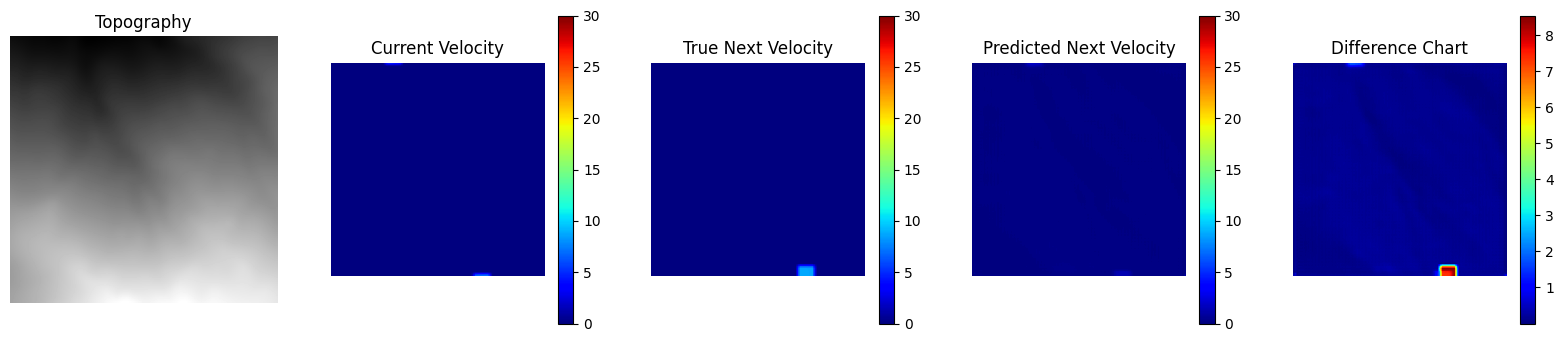

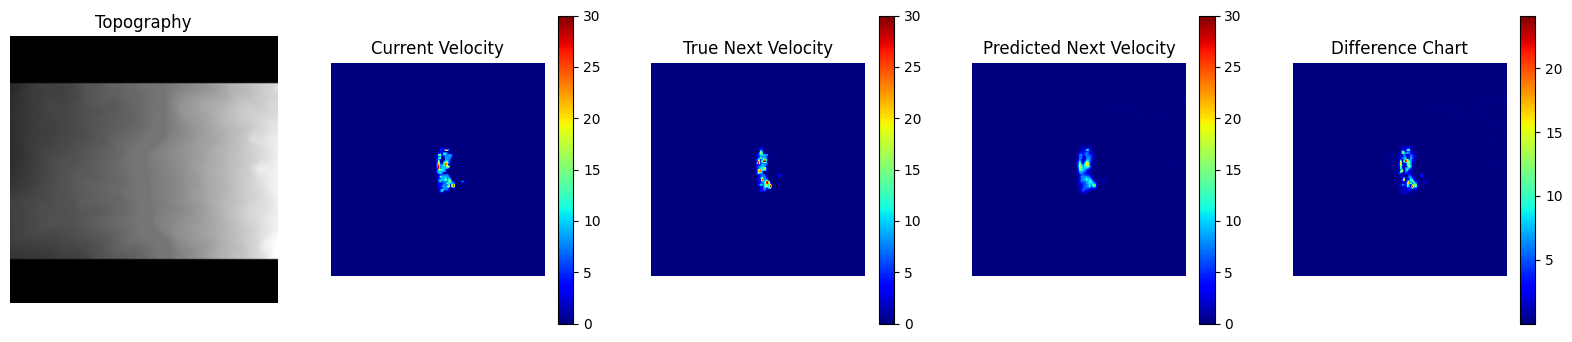

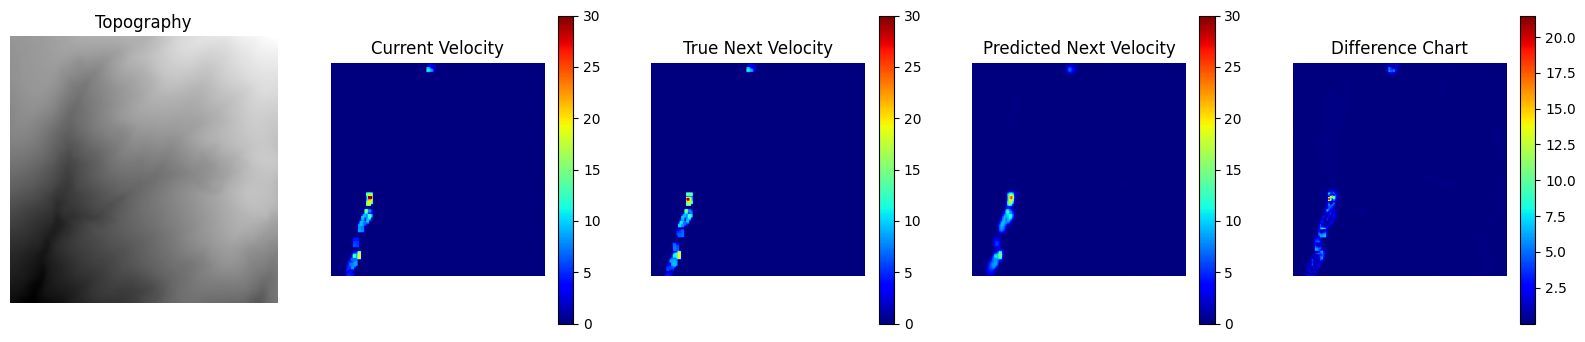

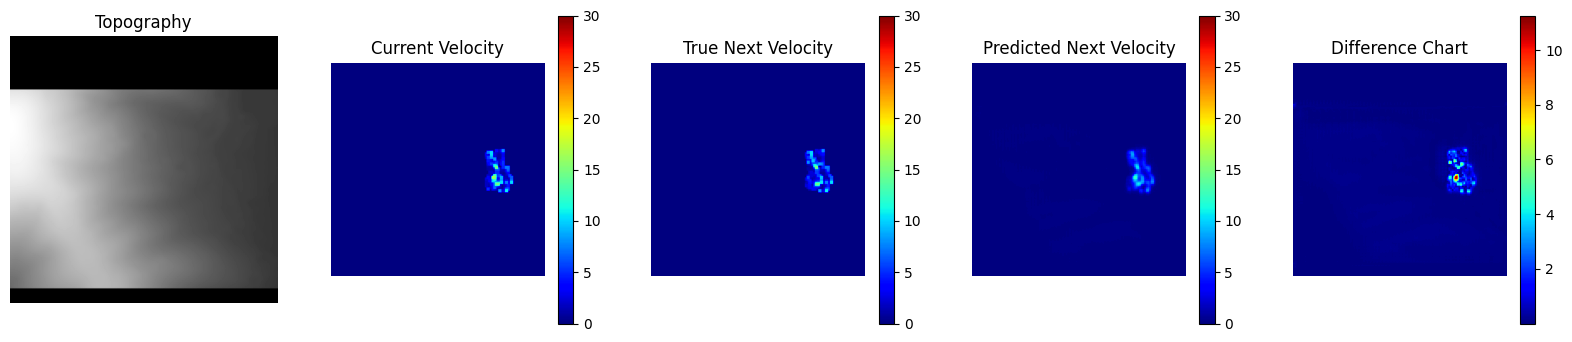

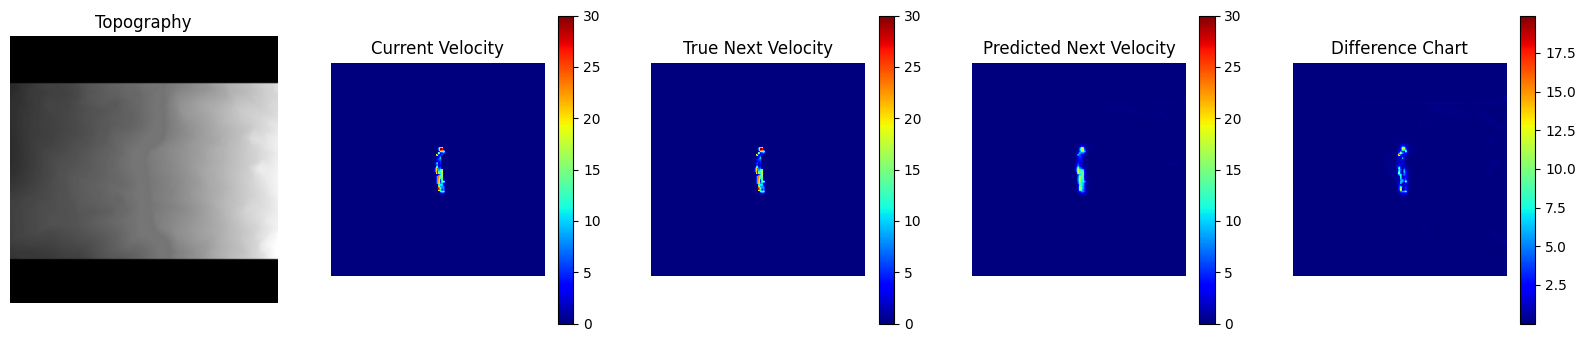

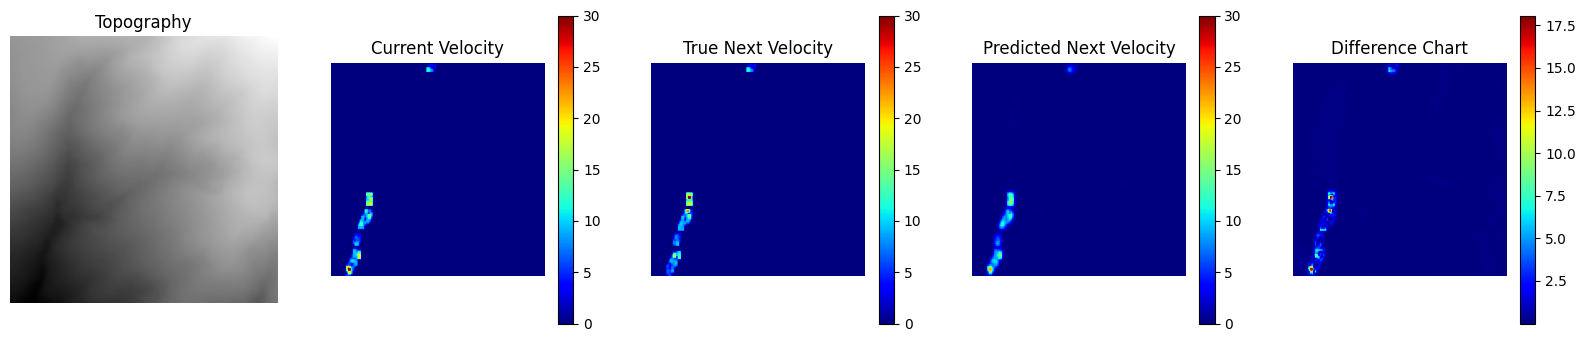

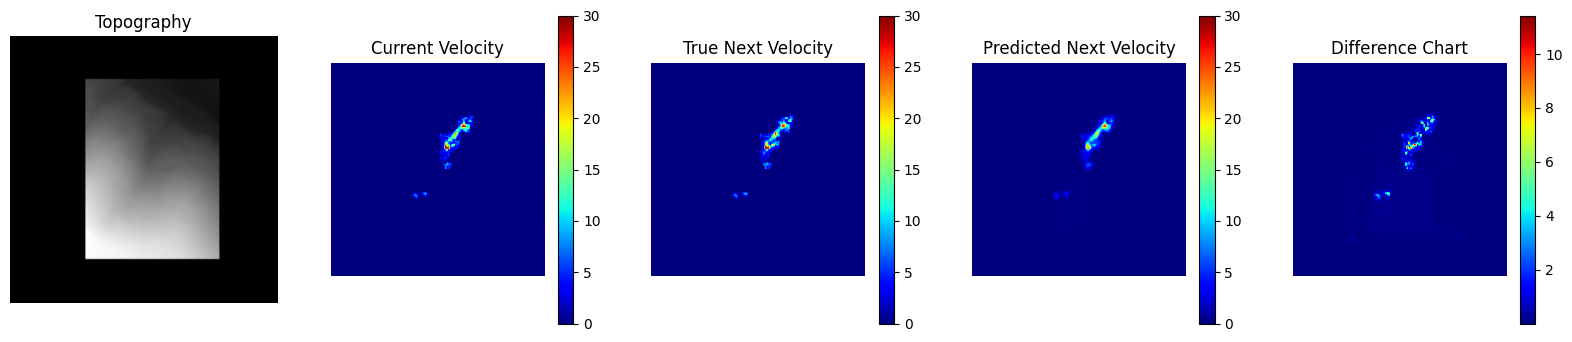

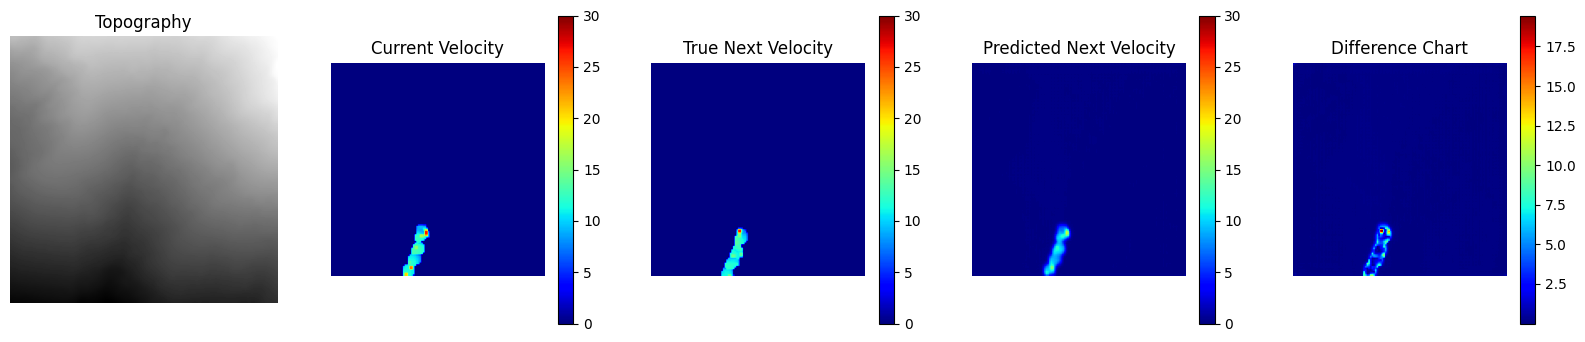

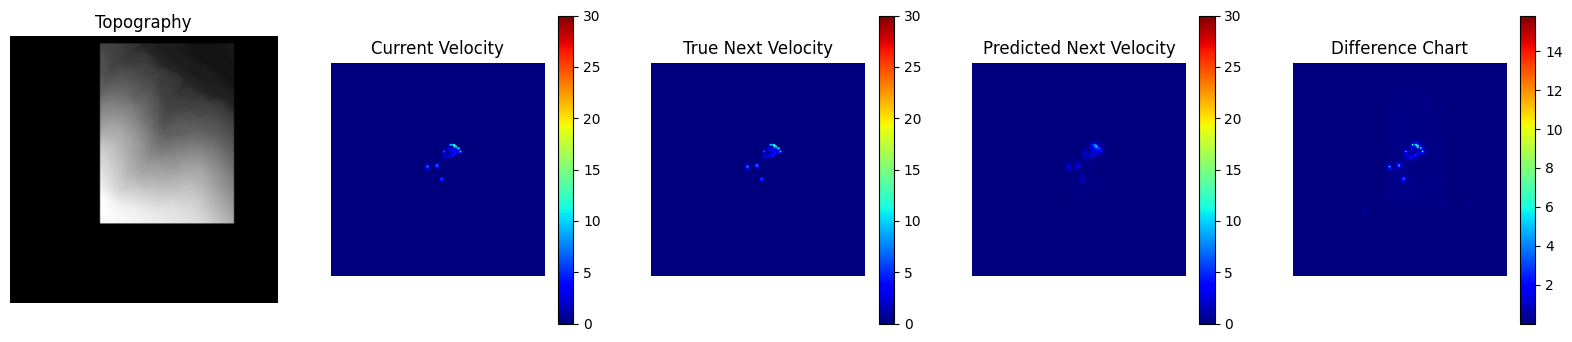

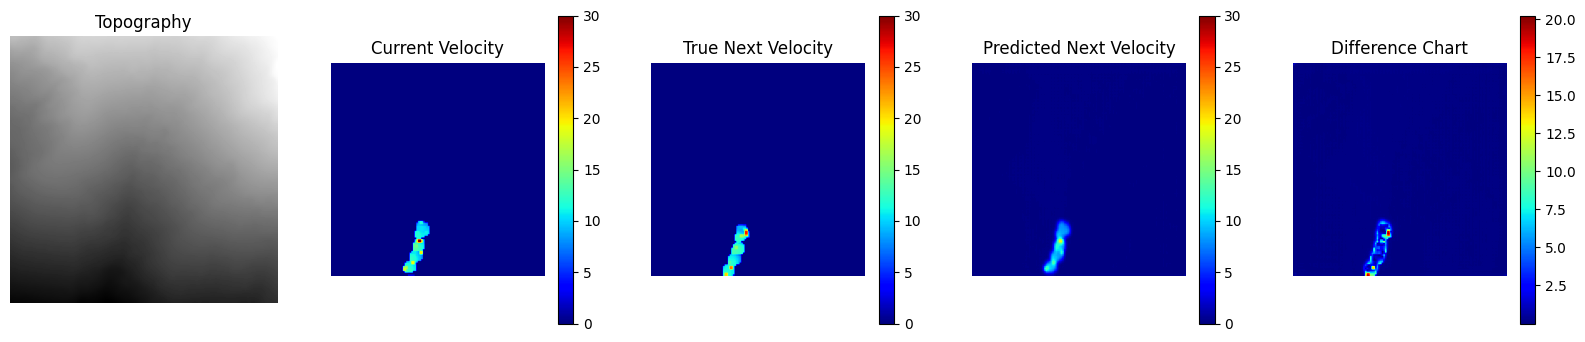

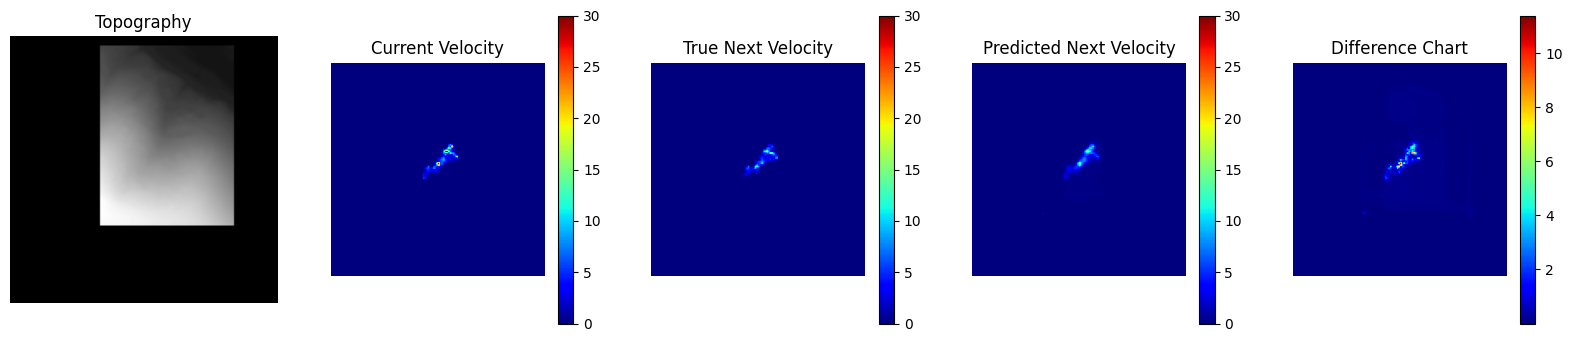

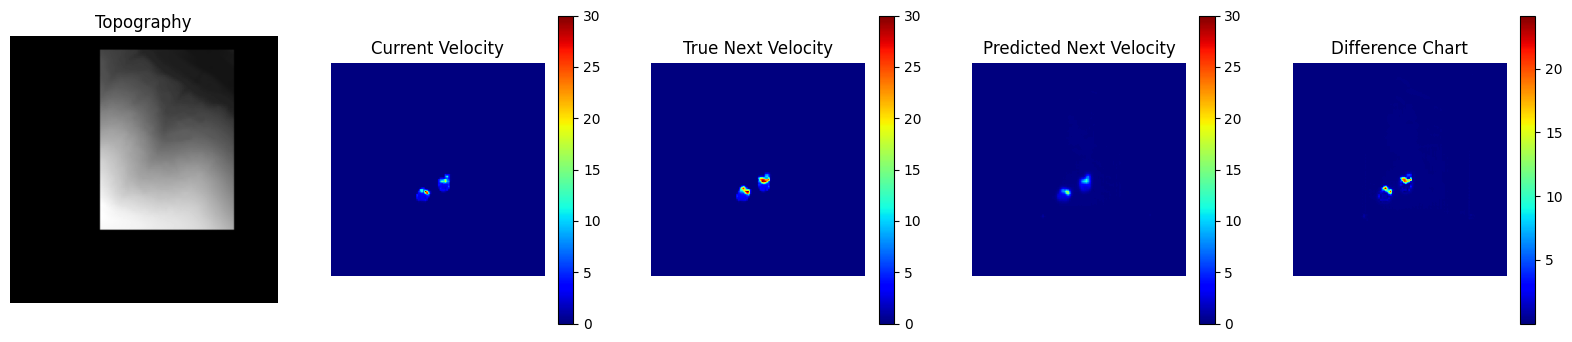

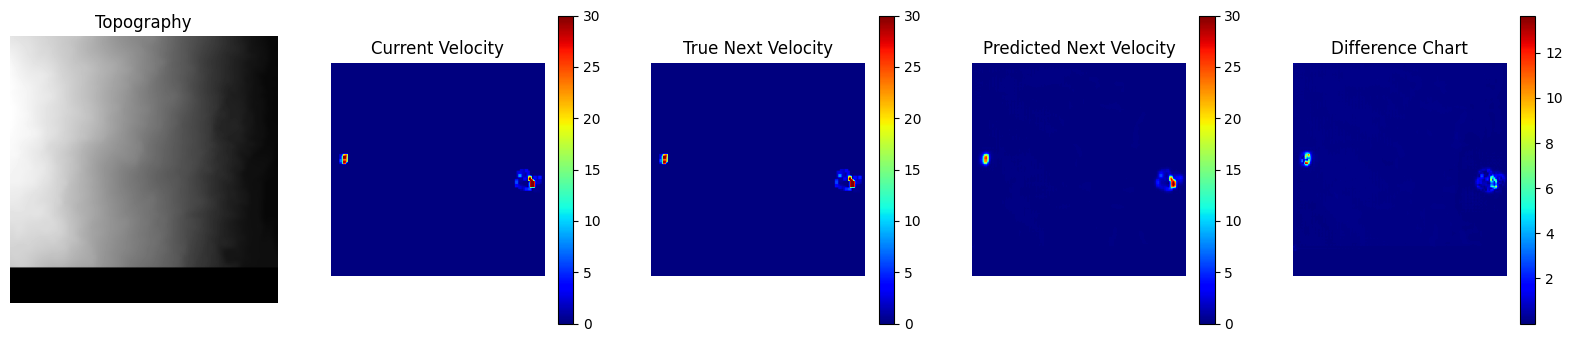

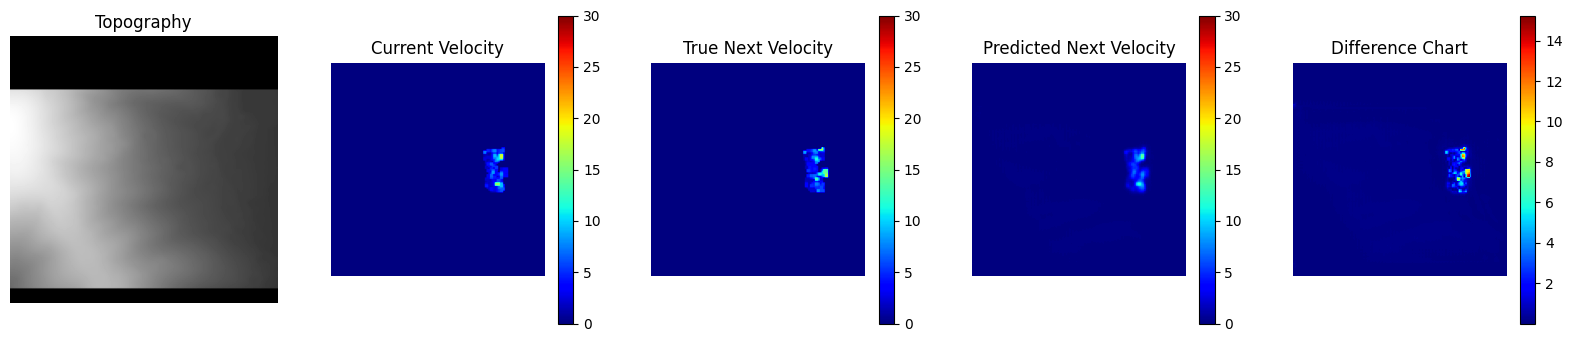

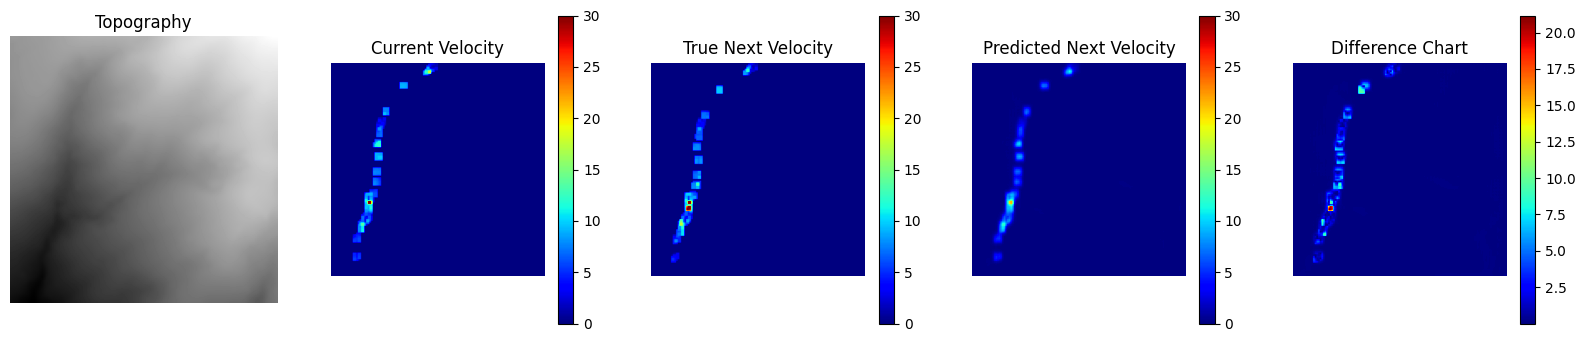

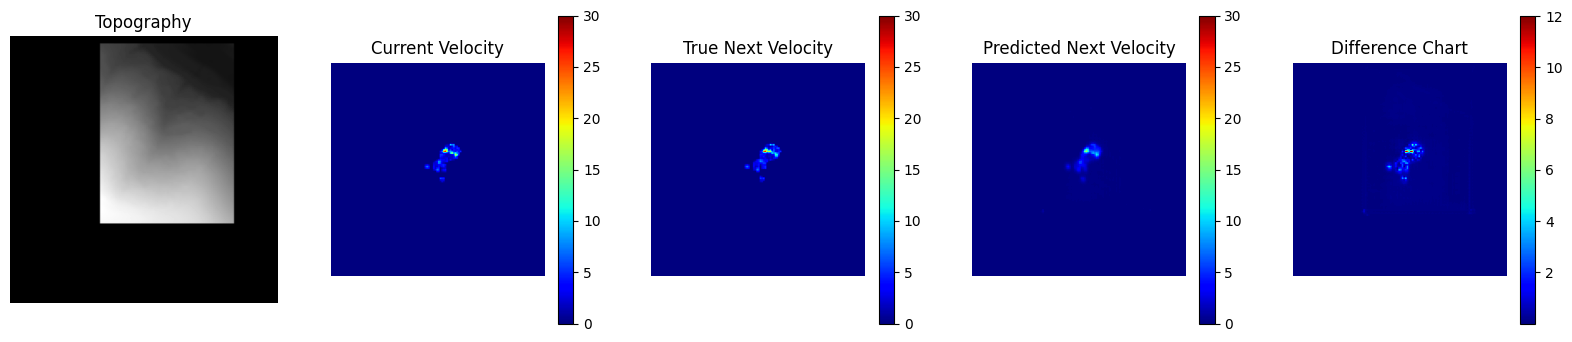

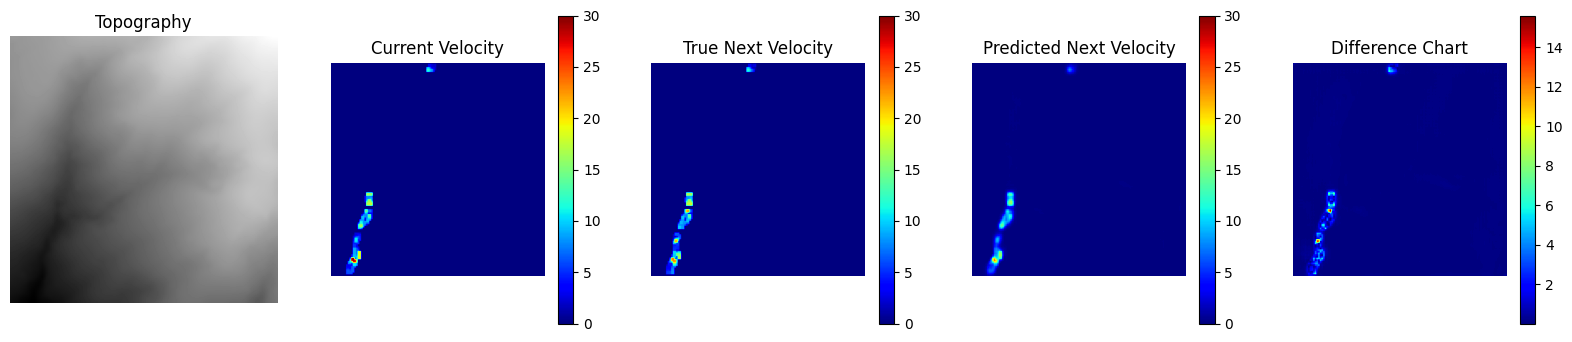

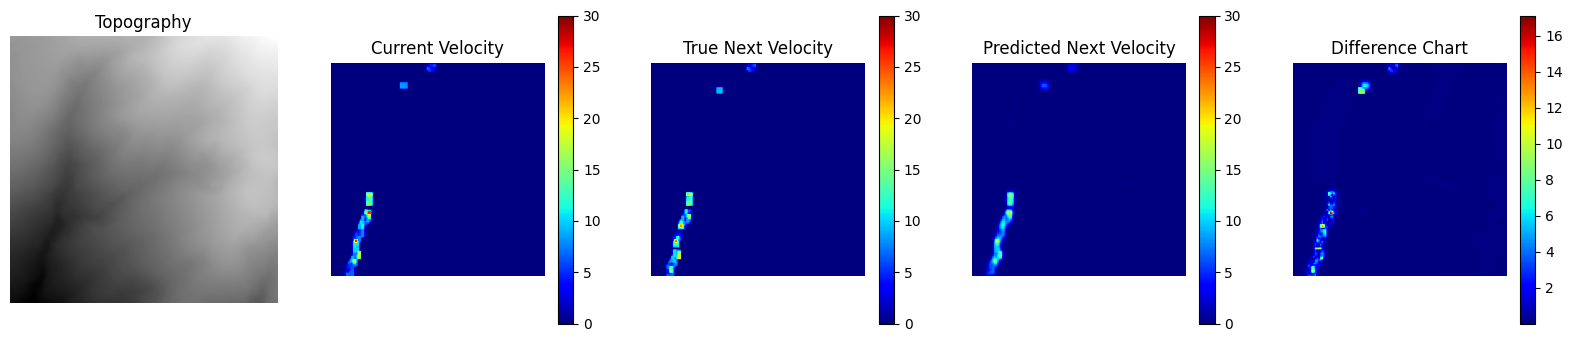

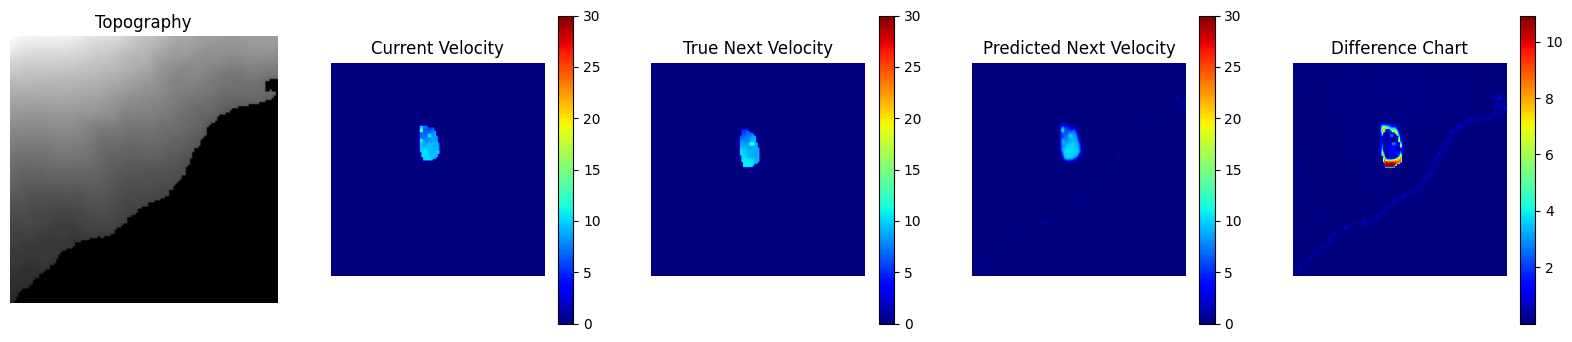

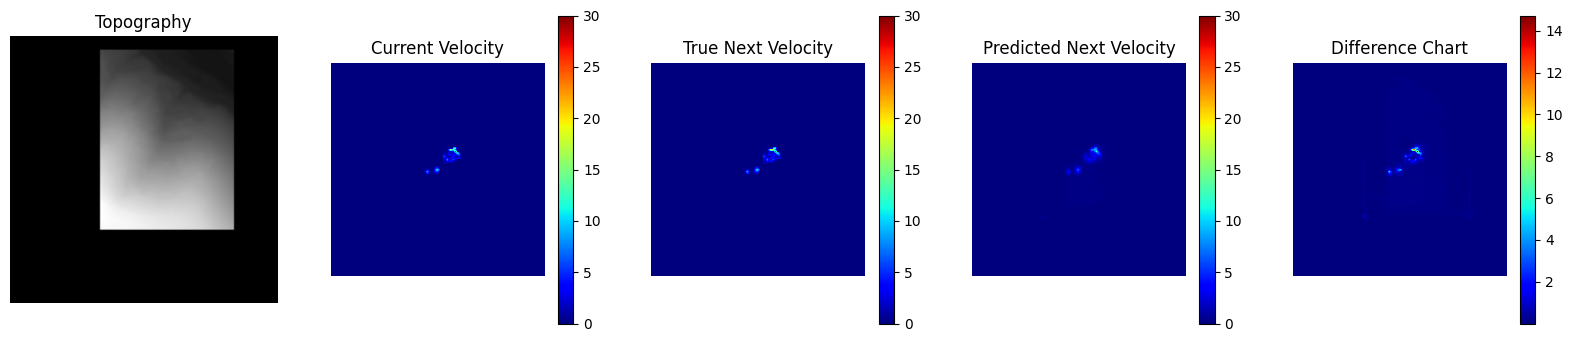

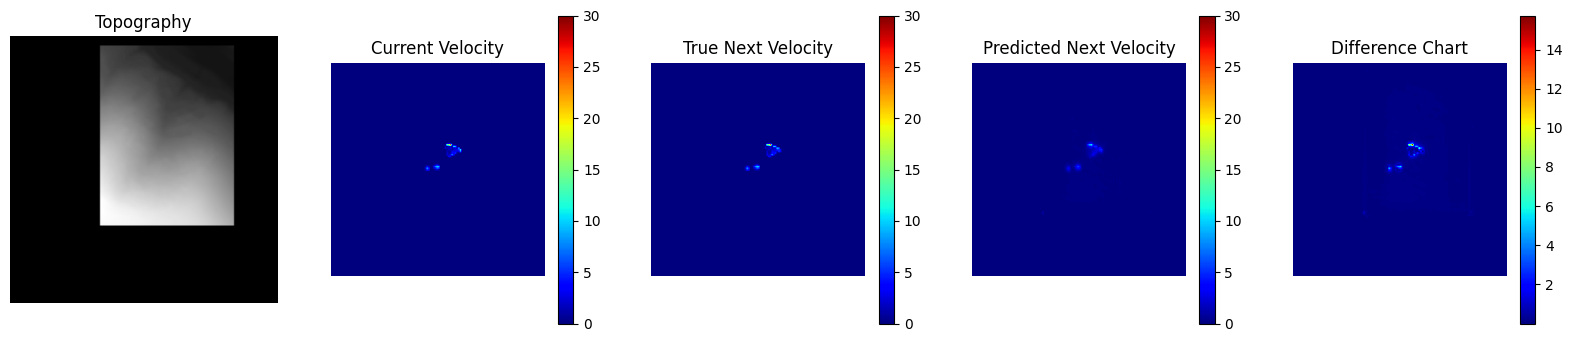

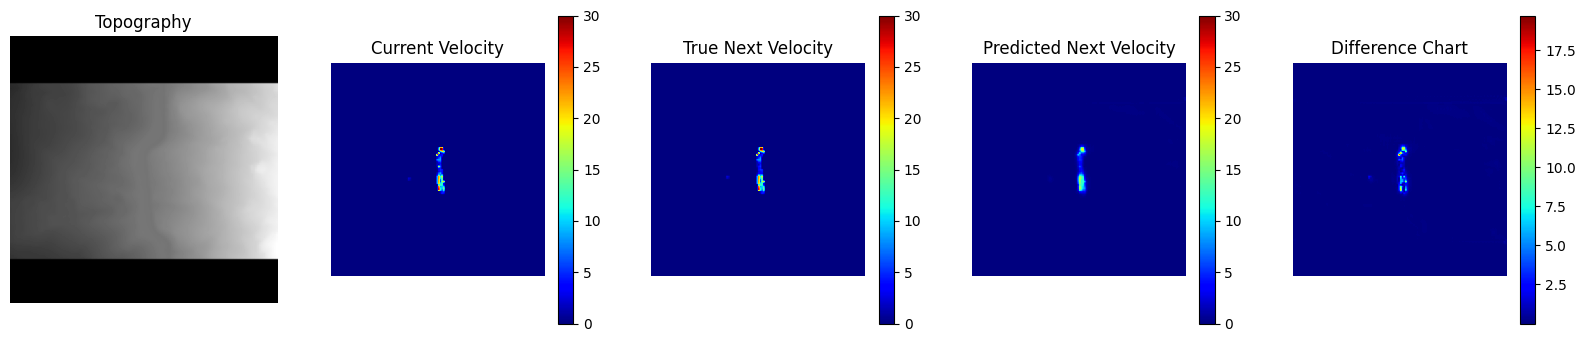

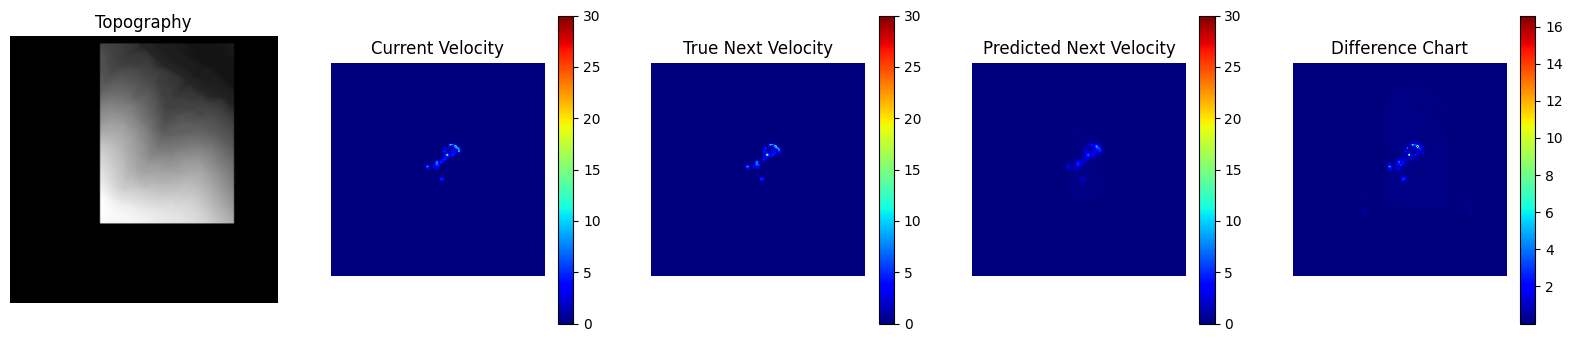

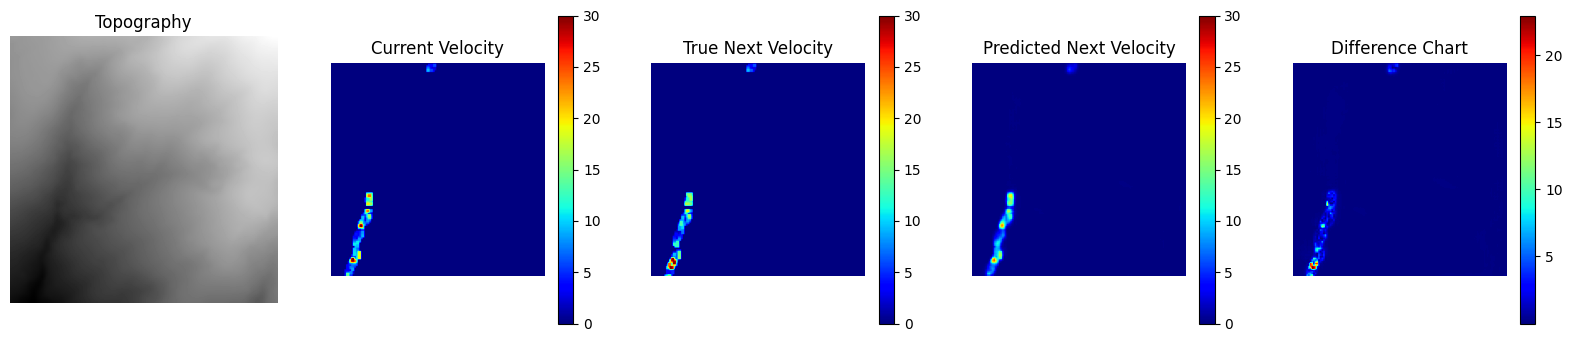

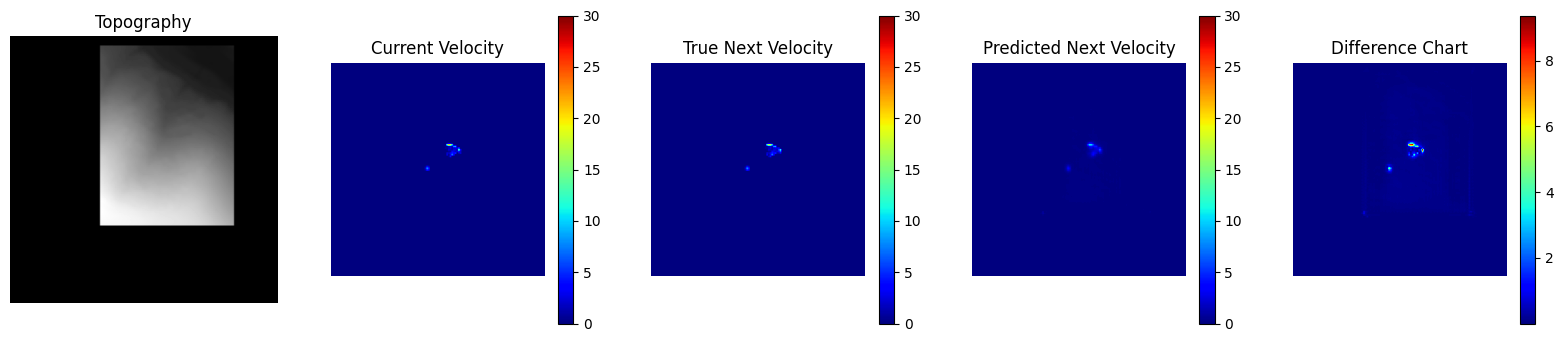

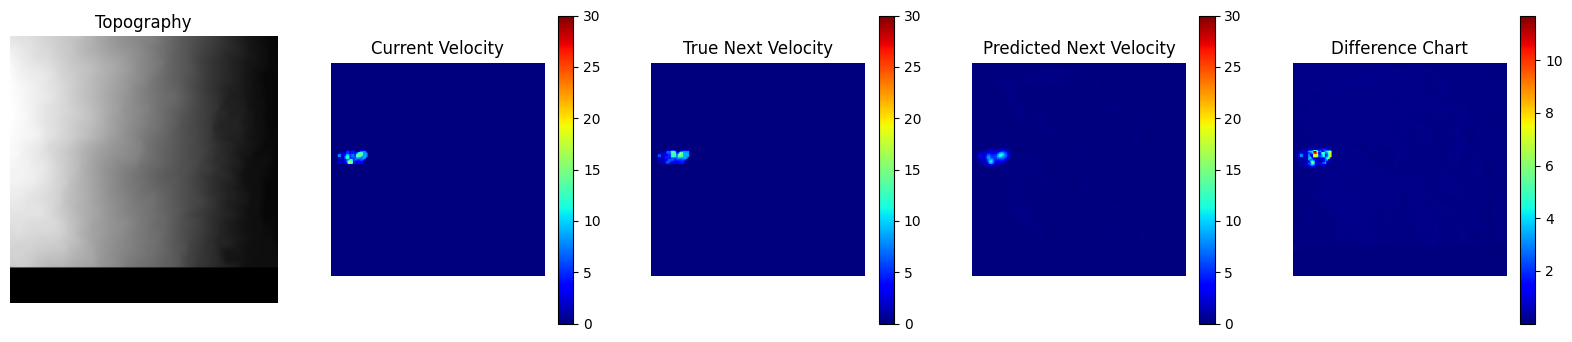

In [16]:
plot_predictions(model, test_loader, device='cuda')